> Federated Learning workflow with Autonomous client and model aggregation methos selection

### 1. Import Libraries

In [ ]:
from collections import deque
import copy
from dataclasses import dataclass, asdict
import json
import logging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from typing import Dict, List, Optional, Tuple
import time
import random
import seaborn as sns
import syft as sy

import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Initialize a hook
hook = sy.TorchHook(torch)

### 2. Model building

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def local_train(model, loader, epochs=1, lr=0.01):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for _ in range(epochs):
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model.state_dict()

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f"✅ Global model accuracy: {accuracy:.4f}")
    return accuracy


### 3. Dataset preparation

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset once
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_loader = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform), batch_size=64)

# Split for 2 clients (simulate decentralized data)
client1_data = Subset(train_dataset, range(0, 30000))
client2_data = Subset(train_dataset, range(30000, 60000))

client1_loader = DataLoader(client1_data, batch_size=64, shuffle=True)
client2_loader = DataLoader(client2_data, batch_size=64, shuffle=True)


### 4. IoT devices/clients building

In [ ]:
# IoT Device and Gateway Communication Simulation
@dataclass
class BatteryState:
    design_capacity: float  # mAh
    current_level: float  # percentage (0-100)
    voltage: float       # volts
    discharge_rate: float # mA/h
    estimated_remaining: float # hours
    temperature: float   # Celsius (affects battery performance)
    actual_capacity: float = 0.0 # mAh

@dataclass
class BandwidthState:
    uplink_capacity: float    # Mbps
    uplink_usage: float       # Mbps
    downlink_capacity: float  # Mbps
    downlink_usage: float     # Mbps
    packet_loss: float        # percentage
    latency: float           # milliseconds
    jitter: float            # milliseconds

@dataclass
class MemoryState:
    total_ram: int          # KB
    used_ram: int           # KB
    free_ram: int           # KB
    buffer_usage: int       # KB
    fragmentation: float    # percentage

@dataclass
class Packet:
    source_id: str
    destination: str
    size: int              # bytes
    timestamp: float
    packet_type: str
    priority: int          # 1-5 (5 = highest priority)
    retry_count: int       # number of retransmission attempts
    data: Optional[Dict] = None


In [ ]:
class IoTDevice:
    def __init__(
        self,
        device_id: str,
        device_type: str = "sensor",
        initial_battery: float = 100.0,
        location: Tuple[float, float] = (0.0, 0.0),
        ml_model: SimpleNet = SimpleNet(),
        train_loader: DataLoader = None,
    ):
        self.device_id = device_id
        self.device_type = device_type
        self.location = location  # (x, y) coordinates
        self.creation_time = time.time()

        # ML model for federated learning
        self.ml_model = ml_model
        self.train_loader = train_loader

        # Real-world IoT device specifications
        device_specs = self._get_device_specifications(device_type)

        self.battery = BatteryState(
            design_capacity=device_specs["battery_capacity"],
            actual_capacity=device_specs[
                "battery_capacity"
            ],  # Initial capacity matches design
            current_level=initial_battery,
            voltage=device_specs["battery_voltage"],
            discharge_rate=device_specs["discharge_rate"],  # Real mAh consumption
            estimated_remaining=0.0,
            temperature=random.uniform(20.0, 35.0),  # Operating temperature
        )

        # Real-world IoT connectivity (varies with network conditions)
        self.bandwidth = BandwidthState(
            uplink_capacity=device_specs["max_uplink"],
            uplink_usage=0.0,
            downlink_capacity=device_specs["max_downlink"],
            downlink_usage=0.0,
            packet_loss=0.0,
            latency=random.uniform(10, 50),  # Base latency in ms
            jitter=random.uniform(1, 5),  # Base jitter in ms
        )

        # Real-world IoT memory constraints
        self.memory = MemoryState(
            total_ram=device_specs["total_ram"],
            used_ram=0,
            free_ram=0,
            buffer_usage=0,
            fragmentation=0.0,
        )

        self.is_active = True
        self.packet_queue = deque(maxlen=device_specs["queue_limit"])
        self.last_transmission = time.time()
        self.network_condition = "GOOD"  # Current network state
        self.energy_harvesting = device_specs.get("energy_harvesting", False)
        self.sleep_mode = False

        # Update initial memory state
        self.stats = {
            "packets_sent": 0,
            "packets_failed": 0,
            "total_data_sent": 0,
            "avg_power_consumption": 0.0,
            "connection_uptime": 0.0,
        }

        self._update_memory_state()
        logger.info(
            f"Device {device_id} ({device_type}) initialized at {location} with {self.battery.design_capacity}mAh battery"
        )

    def _get_device_specifications(self, device_type: str) -> Dict:
        """Get realistic specifications for different IoT device types"""
        specs = {
            "sensor": {
                "total_ram": random.randint(8, 64),
                "battery_voltage": 3.3,
                "battery_capacity": random.uniform(500, 2000),
                "discharge_rate": random.uniform(0.5, 5.0),  # mAh/h
                "max_uplink": 0.025,  # LoRaWAN typical
                "max_downlink": 0.025,
                "queue_limit": 10,
                "energy_harvesting": random.choice(
                    [True, False]
                ),  # Some sensors have solar panels
            },
            "actuator": {
                "total_ram": random.randint(16, 128),
                "battery_voltage": 3.7,
                "battery_capacity": random.uniform(1000, 3000),
                "discharge_rate": random.uniform(5.0, 20.0),
                "max_uplink": 0.1,
                "max_downlink": 0.2,
                "queue_limit": 20,
                "energy_harvesting": False,
            },
            "camera": {
                "total_ram": random.randint(512, 2048),
                "battery_voltage": 3.7,
                "battery_capacity": random.uniform(3000, 8000),
                "discharge_rate": random.uniform(50.0, 200.0),
                "max_uplink": 2.0,
                "max_downlink": 0.5,
                "queue_limit": 50,
                "energy_harvesting": False,
            },
            "gateway": {
                "total_ram": random.randint(1024, 8192),
                "battery_voltage": 5.0,
                "battery_capacity": random.uniform(10000, 20000),
                "discharge_rate": random.uniform(100.0, 500.0),
                "max_uplink": 10.0,
                "max_downlink": 10.0,
                "queue_limit": 100,
                "energy_harvesting": False,
            },
            "tracker": {
                "total_ram": random.randint(32, 256),
                "battery_voltage": 3.6,
                "battery_capacity": random.uniform(800, 2500),
                "discharge_rate": random.uniform(2.0, 15.0),
                "max_uplink": 0.05,
                "max_downlink": 0.05,
                "queue_limit": 15,
                "energy_harvesting": random.choice([True, False]),
            },
        }
        return specs.get(device_type, specs["sensor"])

    def _update_battery_state(self, transmission_cost: float = 0.1):
        """Simulate realistic battery discharge based on device type and activity"""
        if self.battery.current_level <= 0:
            return

        # Temperature affects battery performance
        temp_factor = 1.0
        if self.battery.temperature > 35:
            temp_factor = 1.2  # Higher temperature = faster discharge
        elif self.battery.temperature < 10:
            temp_factor = 1.3  # Cold also affects battery

        # Base discharge calculation
        base_discharge = (
            self.battery.discharge_rate / 3600
        ) * temp_factor  # Convert mA/h to mA/s

        # Sleep mode reduces power consumption significantly
        if self.sleep_mode:
            base_discharge *= 0.1

        # Additional cost for transmission (varies by device type)
        transmission_multiplier = {
            "sensor": 0.1,  # Very low transmission cost
            "actuator": 0.5,  # Moderate cost
            "camera": 2.0,  # High cost for image data
            "gateway": 1.0,  # Standard cost
            "tracker": 0.3,  # GPS transmission cost
        }.get(self.device_type, 0.5)

        if self.network_condition == "BAD":
            transmission_multiplier *= 2.0  # More retransmissions

        total_discharge = base_discharge + (transmission_cost * transmission_multiplier)

        # Energy harvesting can offset some consumption
        if self.energy_harvesting and random.random() < 0.3:  # 30% chance of harvesting
            harvest_amount = random.uniform(0.1, 1.0)
            total_discharge = max(0, total_discharge - harvest_amount)

        # Battery aging simulation (capacity degrades over time)
        age_factor = min(
            1.0, (time.time() - self.creation_time) / (365 * 24 * 3600)
        )  # Age in years
        capacity_degradation = 0.8 + (
            0.2 * (1 - age_factor)
        )  # 80-100% capacity based on age
        self.battery.actual_capacity = (
            self.battery.design_capacity * capacity_degradation
        )

        # Convert mAh consumption to percentage based on ACTUAL capacity
        percentage_consumed = (total_discharge / self.battery.actual_capacity) * 100
        self.battery.current_level = max(
            0, self.battery.current_level - percentage_consumed
        )

        # Realistic voltage curve (Li-ion battery behavior)
        if self.battery.current_level > 80:
            self.battery.voltage = self.battery.voltage * 0.98  # Slight drop from peak
        elif self.battery.current_level > 20:
            voltage_base = 2.8 if self.device_type == "sensor" else 3.0
            self.battery.voltage = self.battery.voltage * (
                0.7 * (self.battery.current_level / 100) + 0.28
            )
        else:
            self.battery.voltage = self.battery.voltage * (
                0.5 * (self.battery.current_level / 100) + 0.2
            )  # Steep drop

        # Time remaining calculation
        if self.battery.discharge_rate > 0:
            hours_remaining = (self.battery.current_level / 100) * (
                self.battery.actual_capacity / self.battery.discharge_rate
            )
            self.battery.estimated_remaining = max(0, hours_remaining)

        # Update statistics
        self.stats["avg_power_consumption"] = (
            self.stats["avg_power_consumption"] * 0.9 + total_discharge * 0.1
        )

    def _update_memory_state(self):
        """Simulate realistic IoT memory usage patterns"""
        # Base OS/firmware overhead (varies by device type)
        base_usage = {
            "sensor": random.randint(2, 8),  # 2-8 KB for basic firmware
            "actuator": random.randint(4, 16),  # 4-16 KB for control logic
            "camera": random.randint(100, 300),  # 100-300 KB for image processing
            "gateway": random.randint(200, 800),  # 200-800 KB for routing
            "tracker": random.randint(8, 32),  # 8-32 KB for GPS/cellular
        }.get(
            self.device_type, 8
        )  # Default to 8 KB for unknown types

        # Application data (queue overhead)
        queue_overhead = len(self.packet_queue) * 2  # 2 KB per queued packet

        # Dynamic buffer usage based on network activity
        if self.network_condition == "BAD":
            buffer_multiplier = 1.5  # More buffering needed
        else:
            buffer_multiplier = 1.0

        # Buffer usage (network buffers, temporary data)
        buffer_range = {
            "sensor": (1, 4),  # Minimal buffering
            "actuator": (2, 8),  # Small buffers
            "camera": (50, 200),  # Large image buffers
            "gateway": (100, 500),  # Routing buffers
            "tracker": (4, 16),  # GPS data buffers
        }.get(self.device_type, (2, 8))

        buffer_usage = int(random.randint(*buffer_range) * buffer_multiplier)

        self.memory.used_ram = base_usage + queue_overhead
        self.memory.buffer_usage = buffer_usage
        self.memory.free_ram = max(
            0, self.memory.total_ram - self.memory.used_ram - self.memory.buffer_usage
        )

        # Calculate memory fragmentation
        if self.memory.total_ram > 0:
            usage_ratio = (
                self.memory.used_ram + self.memory.buffer_usage
            ) / self.memory.total_ram
            self.memory.fragmentation = min(
                usage_ratio * random.uniform(0.1, 0.3) * 100, 30.0
            )

    def _simulate_network_conditions(self):
        """Simulate realistic network conditions (GOOD/BAD states)"""
        # Distance from origin affects signal quality
        distance_from_gateway = np.sqrt(self.location[0] ** 2 + self.location[1] ** 2)
        distance_factor = min(
            distance_from_gateway / 100.0, 1.0
        )  # Max distance effect = 100 units

        # Random network condition changes
        if random.random() < 0.05:  # 5% chance to change state
            self.network_condition = (
                "BAD" if self.network_condition == "GOOD" else "GOOD"
            )

        # Calculate packet loss based on network condition and distance
        if self.network_condition == "BAD":
            base_packet_loss = 5.0 + random.uniform(0, 15) + (distance_factor * 10)
            self.bandwidth.latency = random.uniform(100, 500) + (distance_factor * 100)
            self.bandwidth.jitter = random.uniform(10, 50) + (distance_factor * 20)
        else:
            base_packet_loss = random.uniform(0, 3) + (distance_factor * 2)
            self.bandwidth.latency = random.uniform(10, 50) + (distance_factor * 20)
            self.bandwidth.jitter = random.uniform(1, 10) + (distance_factor * 5)

        return base_packet_loss

    def _update_bandwidth_state(self, packet_size: int):
        """Update bandwidth usage with realistic network behavior"""
        base_packet_loss = self._simulate_network_conditions()

        # Calculate transmission time based on current network conditions
        if self.network_condition == "BAD":
            transmission_time = random.uniform(0.5, 3.0)  # Slower transmission
        else:
            transmission_time = random.uniform(0.1, 0.5)  # Fast transmission

        # Add congestion delay for large packets
        if packet_size > 1000:
            transmission_time *= 1.5

        data_rate = (packet_size * 8) / (transmission_time * 1_000_000)
        self.bandwidth.uplink_usage = min(data_rate, self.bandwidth.uplink_capacity)

        # Advanced packet loss modeling
        usage_ratio = self.bandwidth.uplink_usage / max(
            self.bandwidth.uplink_capacity, 0.001
        )
        congestion_loss = max(
            0, (usage_ratio - 0.6) * 20
        )  # Congestion starts at 60% usage

        self.bandwidth.packet_loss = min(base_packet_loss + congestion_loss, 50.0)

        # Simulate retransmissions due to packet loss (affects power)
        if self.bandwidth.packet_loss > 10:
            return packet_size * 0.3  # 30% additional transmission cost for retries
        return 0

    def train_model_and_generate_packet(
        self,
        destination: str = "gateway",
        epochs: int = 1,
        global_update: SimpleNet = None,
        round_num: int = 1,
    ) -> Packet:
        """Enhanced packet generation with priority and adaptive sizing"""
        packet_types = ["global_model", "local_update"]

        # Load global updated model if available
        self.ml_model.load_state_dict(global_update.state_dict())
        # Local model training
        local_update = local_train(self.ml_model, self.train_loader, epochs=epochs)
        packet_size = len(json.dumps(local_update.state_dict()).encode()) / (
            1024 * 1024
        )  # MB

        packet = Packet(
            source_id=self.device_id,
            destination=destination,
            size=packet_size,
            timestamp=time.time(),
            packet_type=packet_types[1],
            retry_count=0,
            data={
                "local_update": local_update,
                "resources_info": {
                    "battery": asdict(self.battery),
                    "bandwidth": asdict(self.bandwidth),
                    "memory": asdict(self.memory),
                    "location": self.location,
                    "stats": self.stats.copy(),
                },
            },
        )

        if len(self.packet_queue) < self.packet_queue.maxlen:
            self.packet_queue.append(packet)
        else:
            logger.warning(f"Packet queue full for device {self.device_id}")

        return packet

    def transmit_packet(self) -> Optional[Packet]:
        """Simulate packet transmission with resource updates"""
        if not self.packet_queue or self.battery.current_level < 5:
            return None

        # Enter sleep mode if battery is very low
        if self.battery.current_level < 10:
            self.sleep_mode = True
        else:
            self.sleep_mode = False

        packet = self.packet_queue.popleft()

        # Calculate transmission success probability
        success_probability = 0.95  # Base success rate
        if self.network_condition == "BAD":
            success_probability = 0.7
        if self.bandwidth.packet_loss > 10:
            success_probability *= 0.8

        # Simulate transmission attempt
        if random.random() > success_probability:
            packet.retry_count += 1
            if packet.retry_count < 3:  # Allow up to 3 retries
                self.packet_queue.appendleft(packet)  # Put back at front of queue
                self.stats["packets_failed"] += 1
                return None

        # Successful transmission
        self._update_battery_state(packet.size * 0.001)
        self._update_bandwidth_state(packet.size)
        self._update_memory_state()

        self.last_transmission = time.time()
        self.stats["packets_sent"] += 1
        self.stats["total_data_sent"] += packet.size

        return packet

    def get_status(self) -> Dict:
        """Get current device status"""
        uptime = time.time() - self.creation_time
        self.stats["connection_uptime"] = uptime

        return {
            "device_id": self.device_id,
            "device_type": self.device_type,
            "location": self.location,
            "is_active": self.is_active and self.battery.current_level > 0,
            "sleep_mode": self.sleep_mode,
            "battery": asdict(self.battery),
            "bandwidth": asdict(self.bandwidth),
            "memory": asdict(self.memory),
            "queue_size": len(self.packet_queue),
            "last_transmission": self.last_transmission,
            "network_condition": self.network_condition,
            "energy_harvesting": self.energy_harvesting,
            "stats": self.stats.copy(),
            "uptime_hours": uptime / 3600,
        }

### 5. Autonomic Computing building

In [ ]:
class ClientSelectionPolicy:
    """Client/Device selection policy framework"""

    @staticmethod
    def random_selection(
        devices: List[IoTDevice], selection_size: int
    ) -> List[IoTDevice]:
        """Random device selection"""
        eligible_devices = [d for d in devices if d.can_participate()]
        if len(eligible_devices) < selection_size:
            return eligible_devices
        return random.sample(eligible_devices, selection_size)

    @staticmethod
    def resource_aware_selection(
        devices: List[IoTDevice], selection_size: int
    ) -> List[IoTDevice]:
        """Resource-aware device selection (future implementation)"""
        eligible_devices = [d for d in devices if d.can_participate()]

        # Score devices based on resources
        scored_devices = []
        for device in eligible_devices:
            score = (
                device.battery_state.current_level * 0.4
                + (device.memory_state.free_ram / device.memory_state.total_ram)
                * 100
                * 0.3
                + (100 - device.bandwidth_state.packet_loss) * 0.3
            )
            scored_devices.append((device, score))

        # Select top devices
        scored_devices.sort(key=lambda x: x[1], reverse=True)
        return [d[0] for d in scored_devices[:selection_size]]

In [ ]:
class Gateway:
    def __init__(
        self,
        gateway_id: str = "gateway_001",
        location: Tuple[float, float] = (0.0, 0.0),
    ):
        self.gateway_id = gateway_id
        self.location = location
        self.connected_devices: Dict[str, IoTDevice] = {}
        self.selected_devices: Dict[str, IoTDevice] = {}
        self.received_packets: List[Packet] = []
        self.monitoring_data: Dict[str, List[Dict]] = {}
        self.is_running = False
        self.creation_time = time.time()

        # Gateway capabilities
        self.total_bandwidth = 100.0  # Mbps
        self.current_bandwidth_usage = 0.0
        self.max_devices = 1000
        self.packet_processing_delay = 0.001  # seconds per packet

        # Gateway statistics
        self.stats = {
            "total_packets_processed": 0,
            "packets_dropped": 0,
            "average_latency": 0.0,
            "peak_bandwidth_usage": 0.0,
            "device_failures": 0,
        }

        logger.info(f"Gateway {gateway_id} initialized at {location}")

    def register_device(self, device: IoTDevice):
        """Register an IoT device with the gateway"""
        if len(self.connected_devices) >= self.max_devices:
            logger.error(
                f"Gateway capacity exceeded. Cannot register device {device.device_id}"
            )
            return False

        self.connected_devices[device.device_id] = device
        self.monitoring_data[device.device_id] = []
        logger.info(
            f"Device {device.device_id} registered with gateway at {device.location}"
        )
        return True

    def receive_packet(self, packet: Packet):
        """Process received packet and extract monitoring data"""
        processing_start = time.time()

        # Check if gateway is overloaded
        current_load = len(self.received_packets) * self.packet_processing_delay
        if current_load > 1.0:  # More than 1 second of processing backlog
            self.stats["packets_dropped"] += 1
            logger.warning(
                f"Packet dropped due to gateway overload from {packet.source_id}"
            )
            return False

        self.received_packets.append(packet)
        self.stats["total_packets_processed"] += 1

        # Store monitoring data
        if packet.data and packet.source_id in self.monitoring_data:
            enhanced_data = {
                "timestamp": packet.timestamp,
                "packet_size": packet.size,
                "packet_type": packet.packet_type,
                "priority": packet.priority,
                "retry_count": packet.retry_count,
                "processing_delay": time.time() - processing_start,
                **packet.data,
            }
            self.monitoring_data[packet.source_id].append(enhanced_data)

            # Keep only last 1000 records per device to manage memory
            if len(self.monitoring_data[packet.source_id]) > 1000:
                self.monitoring_data[packet.source_id] = self.monitoring_data[
                    packet.source_id
                ][-1000:]

        # Update gateway statistics
        processing_time = time.time() - processing_start
        self.stats["average_latency"] = (
            self.stats["average_latency"] * 0.9 + processing_time * 0.1
        )

        return True

    def get_network_status(self) -> Dict:
        """Get overall network status"""
        active_devices = sum(
            1
            for dev in self.connected_devices.values()
            if dev.battery.current_level > 0
        )

        low_battery_devices = sum(
            1
            for dev in self.connected_devices.values()
            if dev.battery.current_level < 20
        )

        critical_devices = sum(
            1
            for dev in self.connected_devices.values()
            if dev.battery.current_level < 10
        )

        total_packets = len(self.received_packets)
        avg_packet_size = (
            np.mean([p.size for p in self.received_packets])
            if self.received_packets
            else 0
        )

        # Calculate network health score (0-100)
        health_factors = [
            min(
                active_devices / max(len(self.connected_devices), 1) * 100, 100
            ),  # Device availability
            max(
                100 - (self.stats["packets_dropped"] / max(total_packets, 1) * 100), 0
            ),  # Packet success rate
            max(
                100 - (low_battery_devices / max(len(self.connected_devices), 1) * 100),
                0,
            ),  # Battery health
        ]
        network_health = np.mean(health_factors)

        return {
            "gateway_id": self.gateway_id,
            "location": self.location,
            "total_devices": len(self.connected_devices),
            "active_devices": active_devices,
            "low_battery_devices": low_battery_devices,
            "critical_battery_devices": critical_devices,
            "total_packets_received": total_packets,
            "average_packet_size": avg_packet_size,
            "bandwidth_usage": self.current_bandwidth_usage,
            "bandwidth_capacity": self.total_bandwidth,
            "network_health_score": network_health,
            "uptime_hours": (time.time() - self.creation_time) / 3600,
            "stats": self.stats.copy(),
        }

    def select_devices(
        self, devices: List[IoTDevice], selection_size: int, policy: str = "random"
    ) -> None:
        """Select devices for training round"""
        if policy == "random":
            self.selected_devices = ClientSelectionPolicy.random_selection(
                devices, selection_size
            )
        elif policy == "resource_aware":
            self.selected_devices = ClientSelectionPolicy.resource_aware_selection(
                devices, selection_size
            )
        else:
            raise ValueError(f"Unknown policy: {policy}")

    def broadcast_global_model(self, selected_devices: List[IoTDevice], round_num: int):
        """Simulate broadcasting global model to selected devices"""

        # This is a simplified simulation - just record the action
        print(
            f"Round {round_num}: Broadcasting global model to {len(selected_devices)} devices"
        )

    def collect_updates(
        self, selected_devices: List[IoTDevice], round_num: int
    ) -> Dict:
        """Collect local updates from selected devices"""
        round_start_time = time.time()
        successful_updates = []
        failed_transmissions = []
        device_timings = {}

        for device in selected_devices:
            if not device.can_participate():
                failed_transmissions.append(device.device_id)
                continue

            try:
                # Device trains and creates packet
                packet, training_time = device.train_and_create_packet(
                    epochs=5, round_num=round_num
                )

                # Device transmits packet
                success, transmission_time = device.transmit_packet(packet)

                total_device_time = training_time + transmission_time
                device_timings[device.device_id] = {
                    "training_time": training_time,
                    "transmission_time": transmission_time,
                    "total_time": total_device_time,
                    "success": success,
                }

                if success:
                    successful_updates.append(packet.to_dict())
                    self.packet_history.append(packet.to_dict())
                else:
                    failed_transmissions.append(device.device_id)

            except Exception as e:
                print(f"Device {device.device_id} failed: {str(e)}")
                failed_transmissions.append(device.device_id)

        round_total_time = time.time() - round_start_time

        # Record round statistics
        round_stats = {
            "round": round_num,
            "selected_devices": len(selected_devices),
            "successful_updates": len(successful_updates),
            "failed_transmissions": len(failed_transmissions),
            "round_duration": round_total_time,
            "device_timings": device_timings,
            "active_devices": len([d for d in selected_devices if d.is_active]),
        }

        self.round_statistics.append(round_stats)

        return round_stats

    ############### Advanced Monitoring and Reporting ################

    def generate_comprehensive_report(self) -> Dict:
        """Generate comprehensive monitoring report"""
        network_status = self.get_network_status()

        device_reports = {}
        alerts = []
        recommendations = []

        for device_id, device in self.connected_devices.items():
            status = device.get_status()
            device_reports[device_id] = status

            # Enhanced alert generation
            if status["battery"]["current_level"] < 5:
                alerts.append(
                    {
                        "severity": "CRITICAL",
                        "type": "BATTERY",
                        "message": f"{device_id}: Battery critically low ({status['battery']['current_level']:.1f}%)",
                        "timestamp": time.time(),
                    }
                )
            elif status["battery"]["current_level"] < 20:
                alerts.append(
                    {
                        "severity": "WARNING",
                        "type": "BATTERY",
                        "message": f"{device_id}: Low battery ({status['battery']['current_level']:.1f}%)",
                        "timestamp": time.time(),
                    }
                )

            if status["memory"]["free_ram"] < 10:
                alerts.append(
                    {
                        "severity": "CRITICAL",
                        "type": "MEMORY",
                        "message": f"{device_id}: Memory critically low ({status['memory']['free_ram']} KB free)",
                        "timestamp": time.time(),
                    }
                )

            if status["bandwidth"]["packet_loss"] > 15:
                alerts.append(
                    {
                        "severity": "WARNING",
                        "type": "NETWORK",
                        "message": f"{device_id}: High packet loss ({status['bandwidth']['packet_loss']:.1f}%)",
                        "timestamp": time.time(),
                    }
                )

            # Generate recommendations
            if status["energy_harvesting"] and status["battery"]["current_level"] < 30:
                recommendations.append(
                    f"{device_id}: Consider optimizing energy harvesting schedule"
                )

            if status["bandwidth"]["packet_loss"] > 10:
                recommendations.append(
                    f"{device_id}: Consider relocating device or improving network infrastructure"
                )

        return {
            "timestamp": time.time(),
            "network_status": network_status,
            "device_reports": device_reports,
            "alerts": alerts,
            "recommendations": recommendations,
            "summary": {
                "total_alerts": len(alerts),
                "critical_alerts": len(
                    [a for a in alerts if a["severity"] == "CRITICAL"]
                ),
                "network_health": network_status["network_health_score"],
                "recommendation_count": len(recommendations),
            },
        }

### 6. Cloud Server building

In [ ]:
class AggregationMethods:
    FED_AVG = "fed_avg"
    FED_MEDIAN = "fed_median"
    FED_ROUND_ROBIN = "fed_round_robin"
    FED_WEIGHTED_AVG = "fed_weighted_avg"
    FED_KRUM = "fed_krum"
    FED_BULYAN = "fed_bulyan"

    def fed_avg(self, weights_list):
        avg_weights = copy.deepcopy(weights_list[0])
        for key in avg_weights:
            for i in range(1, len(weights_list)):
                avg_weights[key] += weights_list[i][key]
            avg_weights[key] = avg_weights[key] / len(weights_list)
        return avg_weights

    def fed_median(self, weights_list):
        median_weights = copy.deepcopy(weights_list[0])
        for key in median_weights:
            all_weights = torch.stack([weights[key] for weights in weights_list], dim=0)
            median_weights[key] = torch.median(all_weights, dim=0).values
        return median_weights
    def fed_round_robin(self, weights_list, round_num):
        index = round_num % len(weights_list)
        return weights_list[index]
    def fed_weighted_avg(self, weights_list, weights):
        avg_weights = copy.deepcopy(weights_list[0])
        total_weight = sum(weights)
        for key in avg_weights:
            avg_weights[key] = sum(weights[i] * weights_list[i][key] for i in range(len(weights_list))) / total_weight
        return avg_weights
    def fed_krum(self, weights_list, f=1):
        num_clients = len(weights_list)
        scores = []
        for i in range(num_clients):
            distances = []
            for j in range(num_clients):
                if i != j:
                    dist = sum(torch.sum((weights_list[i][key] - weights_list[j][key])**2).item() for key in weights_list[i])
                    distances.append(dist)
            distances.sort()
            score = sum(distances[:num_clients - f - 2])
            scores.append(score)
        krum_index = scores.index(min(scores))
        return weights_list[krum_index]
    def fed_bulyan(self, weights_list, f=1):
        num_clients = len(weights_list)
        selected = []
        temp_weights = weights_list.copy()
        for _ in range(num_clients - 2 * f):
            scores = []
            for i in range(len(temp_weights)):
                distances = []
                for j in range(len(temp_weights)):
                    if i != j:
                        dist = sum(torch.sum((temp_weights[i][key] - temp_weights[j][key])**2).item() for key in temp_weights[i])
                        distances.append(dist)
                distances.sort()
                score = sum(distances[:num_clients - f - 2])
                scores.append(score)
            min_index = scores.index(min(scores))
            selected.append(temp_weights[min_index])
            temp_weights.pop(min_index)
        return self.fed_avg(selected)


In [ ]:
class CloudServer:
    def __init__(self, server_id: str = "cloud_server", global_model: SimpleNet = SimpleNet()):
        self.server_id = server_id
        self.connected_gateways: Dict[str, Gateway] = {}
        self.global_model = global_model
        self.global_model_state = None
        self.creation_time = time.time()
        
        # Server capabilities
        self.model_update_interval = 3600  # 1 hour
        self.last_model_update = time.time()
        logger.info(f"Cloud server {server_id} initialized")
        
    def register_gateway(self, gateway: Gateway):
        """Register a gateway with the cloud server"""
        if gateway.gateway_id in self.connected_gateways:
            logger.warning(f"Gateway {gateway.gateway_id} already registered")
            return False
        
        self.connected_gateways[gateway.gateway_id] = gateway
        self.stats['total_devices'] += len(gateway.connected_devices)
        logger.info(f"Gateway {gateway.gateway_id} registered with cloud server")
        return True
    
    def aggregate_model_updates(self, round_num: int = 1, packet: Packet = None):
        """Aggregate model updates from all connected clients/devices"""
        if packet['data']['local_update'] is None:
            self.global_model_state = AggregationMethods.fed_avg(packet['data']['local_update'])
            self.global_model.load_state_dict(self.global_model_state)
            self.last_model_update = time.time()
            logger.info(f"Global model updated with {len(packet['data']['local_update'])} local models")
        else:
            logger.warning("No model updates received for aggregation")
    
    def distribute_global_model(self):
        """Distribute the global model to all connected gateways and their devices"""
        for gateway in self.connected_gateways.values():
            for device in gateway.connected_devices.values():
                device.ml_model.load_state_dict(self.global_model.state_dict())
        logger.info("Global model distributed to all connected devices")



### 7. Run simulation

In [ ]:
class FederatedLearningSystem:
    def __init__(self, num_devices: int = 10, selection_size: int = 6, simulation_area: Tuple[int, int] = (1000, 1000)):
        self.num_devices = num_devices
        self.selection_size = selection_size
        self.gateway = Gateway()
        self.cloud_server = CloudServer()
        self.devices = List[IoTDevice] = []
        self.system_start_time = None
        self.system_end_time = None
        self.simulation_area = simulation_area  # (width, height) in meters
        self.real_time_data: Dict[str, Dict] = {}
        
        # Register gateway with Cloud Server
        self.cloud_server.register_gateway(self.gateway)
    
    # Create devices with configurations
    def add_device(self, device_id: str, device_type: str = "sensor", 
                   initial_battery: float = 100.0, location: Optional[Tuple[float, float]] = None):
        """Add IoT device with enhanced positioning and configuration"""
        if location is None:
            # Random placement within simulation area
            location = (
                random.uniform(0, self.simulation_area[0]),
                random.uniform(0, self.simulation_area[1])
            )
        
        device = IoTDevice(device_id, device_type, initial_battery, location)
        
        if self.gateway.register_device(device):
            self.devices.append(device)
            self.real_time_data[device_id] = {
                'timestamps': [], 'battery': [], 'memory': [], 'bandwidth': [],
                'packet_loss': [], 'latency': [], 'temperature': []
            }
            logger.info(f"Device {device_id} ({device_type}) added at {location}")
            return True
        return False
    
    def add_device_cluster(self, cluster_center: Tuple[float, float], 
                          cluster_radius: float, device_count: int, 
                          device_type: str = "sensor"):
        """Add a cluster of devices around a central point"""
        for i in range(device_count):
            # Random position within cluster radius
            angle = random.uniform(0, 2 * np.pi)
            radius = random.uniform(0, cluster_radius)
            
            x = cluster_center[0] + radius * np.cos(angle)
            y = cluster_center[1] + radius * np.sin(angle)
            
            # Ensure device stays within simulation area
            x = max(0, min(x, self.simulation_area[0]))
            y = max(0, min(y, self.simulation_area[1]))
            
            device_id = f"{device_type}_cluster_{i:01d}"
            self.add_device(device_id, device_type, 
                          initial_battery=random.uniform(70, 100), 
                          location=(x, y))
    
    def run_simulation(self, num_rounds: int = 10, policy: str = "random") -> Dict:
        """Run the complete federated learning simulation"""
        print(f"Starting Federated Learning Simulation")
        print(f"Devices: {self.num_devices}, Selection: {self.selection_size}, Rounds: {num_rounds}")
        print(f"Policy: {policy}")
        print("=" * 60)
        
        self.system_start_time = time.time()
        
        for round_num in range(num_rounds):
            print(f"\n--- Round {round_num + 1}/{num_rounds} ---")
            
            # Record resource states before round
            for device in self.devices:
                device.record_resource_state(round_num)
            
            # Select devices for this round
            selected_devices = self.gateway.select_devices(
                self.devices, self.selection_size, policy
            )
            
            active_devices = len([d for d in self.devices if d.is_active])
            print(f"Active devices: {active_devices}/{self.num_devices}")
            print(f"Selected for training: {len(selected_devices)}")
            
            # Broadcast global model
            self.gateway.broadcast_global_model(selected_devices, round_num)
            
            # Collect updates
            round_stats = self.gateway.collect_updates(selected_devices, round_num)
            
            print(f"Successful updates: {round_stats['successful_updates']}")
            print(f"Failed transmissions: {round_stats['failed_transmissions']}")
            print(f"Round duration: {round_stats['round_duration']:.2f}s")
        
        self.system_end_time = time.time()
        
        # Generate final system report
        system_stats = self._generate_system_statistics()
        
        print("\n" + "=" * 60)
        print("SIMULATION COMPLETED")
        print(f"Total execution time: {system_stats['total_execution_time']:.2f}s")
        print(f"Final active devices: {system_stats['final_active_devices']}/{self.num_devices}")
        print(f"Average round duration: {system_stats['avg_round_duration']:.2f}s")
        
        return system_stats
    
    def _generate_system_statistics(self) -> Dict:
        """Generate comprehensive system statistics"""
        total_time = self.system_end_time - self.system_start_time
        final_active = len([d for d in self.devices if d.is_active])
        
        # Calculate round statistics
        round_durations = [r['round_duration'] for r in self.gateway.round_statistics]
        successful_rates = [r['successful_updates'] / r['selected_devices'] 
                          for r in self.gateway.round_statistics if r['selected_devices'] > 0]
        
        return {
            'total_execution_time': total_time,
            'final_active_devices': final_active,
            'avg_round_duration': np.mean(round_durations),
            'min_round_duration': np.min(round_durations),
            'max_round_duration': np.max(round_durations),
            'avg_success_rate': np.mean(successful_rates),
            'total_packets_sent': len(self.gateway.packet_history),
            'round_statistics': self.gateway.round_statistics
        }


In [ ]:
class EnhancedNetworkSimulator:
    def __init__(self, simulation_area: Tuple[float, float] = (200.0, 200.0)):
        self.gateway = Gateway()
        self.devices: List[IoTDevice] = []
        self.simulation_time = 0
        self.is_running = False
        self.simulation_area = simulation_area
        self.simulation_speed = 1.0  # Speed multiplier
        
        # Enhanced simulation parameters
        self.environmental_factors = {
            'temperature': 25.0,  # Celsius
            'humidity': 50.0,     # Percentage
            'interference_level': 0.1  # 0-1 scale
        }
        
        # Analytics and ML components
        self.anomaly_detector = AnomalyDetector()
        self.performance_predictor = PerformancePredictor()
        
        # Real-time data storage
        self.real_time_data = {}
        self.simulation_history = []
        
        logger.info(f"Enhanced Network Simulator initialized with area {simulation_area}")
    
    def add_device(self, device_id: str, device_type: str = "sensor", 
                   initial_battery: float = 100.0, location: Optional[Tuple[float, float]] = None):
        """Add IoT device with enhanced positioning and configuration"""
        if location is None:
            # Random placement within simulation area
            location = (
                random.uniform(0, self.simulation_area[0]),
                random.uniform(0, self.simulation_area[1])
            )
        
        device = IoTDevice(device_id, device_type, initial_battery, location)
        
        if self.gateway.register_device(device):
            self.devices.append(device)
            self.real_time_data[device_id] = {
                'timestamps': [], 'battery': [], 'memory': [], 'bandwidth': [],
                'packet_loss': [], 'latency': [], 'temperature': []
            }
            logger.info(f"Device {device_id} ({device_type}) added at {location}")
            return True
        return False
    
    def add_device_cluster(self, cluster_center: Tuple[float, float], 
                          cluster_radius: float, device_count: int, 
                          device_type: str = "sensor"):
        """Add a cluster of devices around a central point"""
        for i in range(device_count):
            # Random position within cluster radius
            angle = random.uniform(0, 2 * np.pi)
            radius = random.uniform(0, cluster_radius)
            
            x = cluster_center[0] + radius * np.cos(angle)
            y = cluster_center[1] + radius * np.sin(angle)
            
            # Ensure device stays within simulation area
            x = max(0, min(x, self.simulation_area[0]))
            y = max(0, min(y, self.simulation_area[1]))
            
            device_id = f"{device_type}_cluster_{i:03d}"
            self.add_device(device_id, device_type, 
                          initial_battery=random.uniform(70, 100), 
                          location=(x, y))
    
    def simulate_environmental_changes(self):
        """Simulate environmental factors affecting device performance"""
        # Temperature variation (daily cycle simulation)
        time_of_day = (self.simulation_time % 1440) / 1440  # Normalize to 0-1 (24 hours)
        base_temp = 15 + 15 * np.sin(2 * np.pi * time_of_day)  # 0-30°C daily cycle
        self.environmental_factors['temperature'] = base_temp + random.uniform(-3, 3)
        
        # Humidity changes
        self.environmental_factors['humidity'] = max(0, min(100, 
            self.environmental_factors['humidity'] + random.uniform(-2, 2)))
        
        # Interference level changes (simulates other wireless activity)
        self.environmental_factors['interference_level'] = max(0, min(1,
            self.environmental_factors['interference_level'] + random.uniform(-0.05, 0.05)))
        
        # Apply environmental effects to devices
        for device in self.devices:
            device.battery.temperature = self.environmental_factors['temperature']
            
            # Interference affects network conditions
            if self.environmental_factors['interference_level'] > 0.7:
                if random.random() < 0.3:  # 30% chance to worsen network
                    device.network_condition = "BAD"
    
    def simulate_device_failures(self):
        """Simulate realistic device failures and recovery"""
        for device in self.devices:
            # Battery depletion failure
            if device.battery.current_level <= 0:
                device.is_active = False
                continue
            
            # Random hardware failures (very low probability)
            if random.random() < 0.0001:  # 0.01% chance per simulation step
                device.is_active = False
                logger.warning(f"Device {device.device_id} experienced hardware failure")
                continue
            
            # Network connectivity issues
            distance_to_gateway = np.sqrt(
                (device.location[0] - self.gateway.location[0])**2 + 
                (device.location[1] - self.gateway.location[1])**2
            )
            
            # Devices far from gateway have higher chance of connectivity issues
            if distance_to_gateway > 150:  # Beyond 150 units
                if random.random() < 0.02:  # 2% chance
                    device.network_condition = "BAD"
    
    def simulate_step(self):
        """Enhanced simulation step with comprehensive modeling"""
        self.simulation_time += 1
        
        # Environmental and failure simulation
        if self.simulation_time % 10 == 0:  # Every 10 steps
            self.simulate_environmental_changes()
            self.simulate_device_failures()
        
        # Device simulation
        active_devices = 0
        total_packets = 0
        
        for device in self.devices:
            if not device.is_active or device.battery.current_level <= 0:
                continue
                
            active_devices += 1
            
            # Adaptive transmission probability based on device state
            base_prob = 0.3
            
            # Low battery devices transmit less frequently
            if device.battery.current_level < 20:
                base_prob *= 0.5
            
            # High priority devices (alerts) transmit more frequently
            if device.device_type in ["camera", "tracker"]:
                base_prob *= 1.5
            
            # Environmental factors affect transmission
            if self.environmental_factors['interference_level'] > 0.5:
                base_prob *= 0.8
            
            if random.random() < base_prob:
                # Determine packet priority based on device state
                if device.battery.current_level < 10:
                    priority = 5  # Critical battery alert
                elif device.memory.free_ram < 10:
                    priority = 4  # Memory critical
                elif device.bandwidth.packet_loss > 15:
                    priority = 3  # Network issues
                else:
                    priority = random.randint(1, 3)  # Normal traffic
                
                packet = device.generate_packet(priority=priority)
                if packet:
                    transmitted_packet = device.transmit_packet()
                    if transmitted_packet:
                        success = self.gateway.receive_packet(transmitted_packet)
                        if success:
                            total_packets += 1
        
        # Update real-time data
        self._update_real_time_data()
        
        # Anomaly detection
        if self.simulation_time % 50 == 0:  # Every 50 steps
            self._run_anomaly_detection()
        
        # Performance prediction
        if self.simulation_time % 100 == 0:  # Every 100 steps
            self._run_performance_prediction()
        
        return {
            'active_devices': active_devices,
            'packets_transmitted': total_packets,
            'environmental_factors': self.environmental_factors.copy()
        }
    
    def _update_real_time_data(self):
        """Update real-time monitoring data"""
        current_time = time.time()
        
        for device in self.devices:
            if device.device_id not in self.real_time_data:
                continue
                
            data = self.real_time_data[device.device_id]
            data['timestamps'].append(current_time)
            data['battery'].append(device.battery.current_level)
            data['memory'].append(device.memory.used_ram)
            data['bandwidth'].append(device.bandwidth.uplink_usage)
            data['packet_loss'].append(device.bandwidth.packet_loss)
            data['latency'].append(device.bandwidth.latency)
            data['temperature'].append(device.battery.temperature)
            
            # Keep only recent data (last 1000 points)
            for key in data:
                if len(data[key]) > 1000:
                    data[key] = data[key][-1000:]
    
    def _run_anomaly_detection(self):
        """Run anomaly detection on device metrics"""
        for device_id, device in enumerate(self.devices):
            if not device.is_active:
                continue
                
            metrics = {
                'battery_level': device.battery.current_level,
                'memory_usage': device.memory.used_ram / device.memory.total_ram,
                'packet_loss': device.bandwidth.packet_loss,
                'temperature': device.battery.temperature
            }
            
            anomaly_score = self.anomaly_detector.detect(device.device_id, metrics)
            
            if anomaly_score > 0.8:  # High anomaly score
                logger.warning(f"Anomaly detected in device {device.device_id}: score {anomaly_score:.2f}")
    
    def _run_performance_prediction(self):
        """Run performance prediction models"""
        for device in self.devices:
            if not device.is_active:
                continue
                
            predictions = self.performance_predictor.predict(device)
            
            # Log predictions for critical issues
            if predictions.get('battery_failure_hours', float('inf')) < 24:
                logger.info(f"Device {device.device_id} predicted battery failure in {predictions['battery_failure_hours']:.1f} hours")
    
    def run_simulation(self, duration: int = 1000, step_delay: float = 0.1, 
                      save_history: bool = True):
        """Enhanced simulation runner with comprehensive logging"""
        logger.info(f"Starting enhanced IoT simulation for {duration} steps")
        logger.info(f"Simulation area: {self.simulation_area}, {len(self.devices)} devices")
        
        self.is_running = True
        start_time = time.time()
        
        # Statistics tracking
        step_stats = []
        
        for step in range(duration):
            if not self.is_running:
                break
            
            step_result = self.simulate_step()
            step_stats.append({
                'step': step,
                'timestamp': time.time(),
                **step_result
            })
            
            # Progress reporting
            if step % 50 == 0:
                report = self.gateway.generate_comprehensive_report()
                logger.info(f"Step {step}: Active: {step_result['active_devices']}, "
                          f"Packets: {step_result['packets_transmitted']}, "
                          f"Health: {report['network_status']['network_health_score']:.1f}")
                
                # Display critical alerts
                critical_alerts = [a for a in report['alerts'] if a['severity'] == 'CRITICAL']
                if critical_alerts:
                    logger.warning(f"CRITICAL ALERTS ({len(critical_alerts)}):")
                    for alert in critical_alerts[:3]:  # Show first 3
                        logger.warning(f"  - {alert['message']}")
                
                # Display recommendations
                if report['recommendations']:
                    logger.info(f"RECOMMENDATIONS ({len(report['recommendations'])}):")
                    for rec in report['recommendations'][:2]:  # Show first 2
                        logger.info(f"  - {rec}")
            
            # Save periodic snapshots
            if save_history and step % 100 == 0:
                self.simulation_history.append({
                    'step': step,
                    'timestamp': time.time(),
                    'network_report': self.gateway.generate_comprehensive_report(),
                    'environmental_factors': self.environmental_factors.copy()
                })
            
            time.sleep(step_delay / self.simulation_speed)
        
        simulation_duration = time.time() - start_time
        logger.info(f"Simulation completed in {simulation_duration:.2f} seconds")
        
        # Generate final comprehensive report
        final_report = self.generate_final_report(step_stats)
        return final_report
    
    def generate_final_report(self, step_stats: List[Dict]) -> Dict:
        """Generate comprehensive final simulation report"""
        network_report = self.gateway.generate_comprehensive_report()
        
        # Calculate simulation statistics
        total_steps = len(step_stats)
        avg_active_devices = np.mean([s['active_devices'] for s in step_stats])
        total_packets = sum([s['packets_transmitted'] for s in step_stats])
        
        # Device lifetime analysis
        device_lifetimes = {}
        for device in self.devices:
            if device.battery.current_level <= 0:
                device_lifetimes[device.device_id] = {
                    'lifetime_hours': device.stats['connection_uptime'],
                    'packets_sent': device.stats['packets_sent'],
                    'avg_power_consumption': device.stats['avg_power_consumption']
                }
        
        # Network performance metrics
        avg_packet_loss = np.mean([
            device.bandwidth.packet_loss for device in self.devices if device.is_active
        ])
        avg_latency = np.mean([
            device.bandwidth.latency for device in self.devices if device.is_active
        ])
        
        return {
            'simulation_summary': {
                'total_simulation_steps': total_steps,
                'average_active_devices': avg_active_devices,
                'total_packets_transmitted': total_packets,
                'simulation_area': self.simulation_area,
                'device_count': len(self.devices)
            },
            'network_performance': {
                'average_packet_loss': avg_packet_loss,
                'average_latency': avg_latency,
                'network_health_score': network_report['network_status']['network_health_score'],
                'gateway_stats': network_report['network_status']['stats']
            },
            'device_analysis': {
                'device_lifetimes': device_lifetimes,
                'failed_devices': len(device_lifetimes),
                'active_devices': len([d for d in self.devices if d.is_active])
            },
            'environmental_impact': self.environmental_factors,
            'alerts_summary': {
                'total_alerts': len(network_report['alerts']),
                'critical_alerts': len([a for a in network_report['alerts'] if a['severity'] == 'CRITICAL']),
                'recommendations': len(network_report['recommendations'])
            },
            'detailed_reports': network_report
        }
    
    def create_enhanced_dashboard(self, save_plots: bool = True):
        """Create comprehensive enhanced dashboard"""
        if not self.gateway.monitoring_data:
            logger.warning("No monitoring data available for dashboard")
            return
        
        # Create main dashboard
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Enhanced IoT Network Monitoring Dashboard', fontsize=18, fontweight='bold')
        
        # Create complex grid layout
        gs = fig.add_gridspec(4, 6, hspace=0.4, wspace=0.4)
        
        # Color scheme for devices
        colors = plt.cm.tab20(np.linspace(0, 1, len(self.devices)))
        device_colors = {device.device_id: colors[i] for i, device in enumerate(self.devices)}
        
        # 1. Network Topology Visualization
        ax_topology = fig.add_subplot(gs[0, 0:2])
        self._plot_network_topology(ax_topology, device_colors)
        
        # 2. Real-time Battery Status
        ax_battery = fig.add_subplot(gs[0, 2:4])
        self._plot_enhanced_battery_status(ax_battery, device_colors)
        
        # 3. Environmental Factors
        ax_env = fig.add_subplot(gs[0, 4:6])
        self._plot_environmental_factors(ax_env)
        
        # 4. Device Performance Heatmap
        ax_heatmap = fig.add_subplot(gs[1, 0:2])
        self._plot_performance_summary(ax_heatmap)
        
        # 5. Packet Loss and Latency Analysis
        ax_network = fig.add_subplot(gs[1, 2:4])
        self._plot_network_quality_metrics(ax_network, device_colors)
        
        # 6. Memory Fragmentation Analysis
        ax_memory = fig.add_subplot(gs[1, 4:6])
        self._plot_memory_analysis(ax_memory, device_colors)
        
        # 7. Predictive Analytics
        ax_predict = fig.add_subplot(gs[2, 0:2])
        self._plot_predictive_analytics(ax_predict)
        
        # 8. Anomaly Detection Results
        ax_anomaly = fig.add_subplot(gs[2, 2:4])
        self._plot_anomaly_detection(ax_anomaly)
        
        # 9. Energy Harvesting Analysis
        ax_energy = fig.add_subplot(gs[2, 4:6])
        self._plot_energy_harvesting(ax_energy, device_colors)
        
        # 10. Device Lifecycle Analysis
        ax_lifecycle = fig.add_subplot(gs[3, 0:2])
        self._plot_device_lifecycle(ax_lifecycle, device_colors)
        
        # 11. Alert Timeline
        ax_alerts = fig.add_subplot(gs[3, 2:4])
        self._plot_alert_timeline(ax_alerts)
        
        # 12. Performance Summary
        ax_summary = fig.add_subplot(gs[3, 4:6])
        self._plot_performance_summary(ax_summary)
        
        plt.tight_layout()
        
        # if save_plots:
        #     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        #     filename = f"iot_dashboard_{timestamp}.png"
        #     plt.savefig(filename, dpi=300, bbox_inches='tight')
        #     logger.info(f"Dashboard saved as {filename}")
        
        plt.show()
    
    # Enhanced plotting methods
    def _plot_network_topology(self, ax, device_colors):
        """Plot network topology with device positions"""
        ax.set_title('Network Topology', fontweight='bold', fontsize=12)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        
        # Plot gateway
        ax.scatter(self.gateway.location[0], self.gateway.location[1], 
                  s=500, c='red', marker='s', label='Gateway', edgecolors='black', linewidth=2)
        
        # Plot devices with status-based colors
        for device in self.devices:
            x, y = device.location
            
            # Color based on device health
            if device.battery.current_level < 10:
                color = 'red'
                alpha = 0.5
            elif device.battery.current_level < 30:
                color = 'orange'
                alpha = 0.7
            else:
                color = device_colors[device.device_id]
                alpha = 1.0
            
            # Size based on device type
            sizes = {'sensor': 50, 'actuator': 80, 'camera': 120, 'tracker': 70, 'gateway': 200}
            size = sizes.get(device.device_type, 60)
            
            ax.scatter(x, y, s=size, c=color, alpha=alpha, 
                      label=f'{device.device_id} ({device.device_type})',
                      edgecolors='black', linewidth=1)
            
            # Draw connection lines to gateway (with signal strength indication)
            distance = np.sqrt((x - self.gateway.location[0])**2 + (y - self.gateway.location[1])**2)
            line_alpha = max(0.1, 1.0 - distance/200)  # Fade with distance
            ax.plot([x, self.gateway.location[0]], [y, self.gateway.location[1]], 
                   'k-', alpha=line_alpha, linewidth=1)
        
        ax.set_xlim(0, self.simulation_area[0])
        ax.set_ylim(0, self.simulation_area[1])
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    def _plot_enhanced_battery_status(self, ax, device_colors):
        """Enhanced battery status with predictions"""
        ax.set_title('Battery Status & Predictions', fontweight='bold', fontsize=12)
        
        devices = []
        current_levels = []
        predicted_hours = []
        colors_list = []
        
        for device in self.devices:
            devices.append(device.device_id)
            level = device.battery.current_level
            current_levels.append(level)
            predicted_hours.append(device.battery.estimated_remaining)
            
            # Status-based colors
            if level > 60:
                colors_list.append('green')
            elif level > 30:
                colors_list.append('orange')
            elif level > 10:
                colors_list.append('red')
            else:
                colors_list.append('darkred')
        
        x_pos = np.arange(len(devices))
        bars = ax.barh(x_pos, current_levels, color=colors_list, alpha=0.7, height=0.6)
        
        # Add prediction indicators
        for i, (bar, hours) in enumerate(zip(bars, predicted_hours)):
            if hours < 24:  # Less than 24 hours remaining
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                       f'{hours:.1f}h', ha='left', va='center', fontweight='bold', color='red')
            else:
                ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                       f'{hours:.1f}h', ha='left', va='center')
        
        ax.set_yticks(x_pos)
        ax.set_yticklabels(devices)
        ax.set_xlabel('Battery Level (%) / Remaining Hours')
        ax.set_xlim(0, 120)
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_environmental_factors(self, ax):
        """Plot environmental factors over time"""
        ax.set_title('Environmental Conditions', fontweight='bold', fontsize=12)
        
        if self.simulation_history:
            timestamps = [h['step'] for h in self.simulation_history]
            temperatures = [h['environmental_factors']['temperature'] for h in self.simulation_history]
            humidity = [h['environmental_factors']['humidity'] for h in self.simulation_history]
            interference = [h['environmental_factors']['interference_level'] * 100 for h in self.simulation_history]
            
            ax2 = ax.twinx()
            
            line1 = ax.plot(timestamps, temperatures, 'r-', label='Temperature (°C)', linewidth=2)
            line2 = ax.plot(timestamps, humidity, 'b-', label='Humidity (%)', linewidth=2)
            line3 = ax2.plot(timestamps, interference, 'g-', label='Interference (%)', linewidth=2)
            
            ax.set_xlabel('Simulation Step')
            ax.set_ylabel('Temperature (°C) / Humidity (%)')
            ax2.set_ylabel('Interference Level (%)')
            
            # Combine legends
            lines = line1 + line2 + line3
            labels = [l.get_label() for l in lines]
            ax.legend(lines, labels, loc='upper right')
        else:
            ax.text(0.5, 0.5, 'No environmental data available', 
                   ha='center', va='center', transform=ax.transAxes)
        
        ax.grid(True, alpha=0.3)
    
    # Additional plotting methods would continue here...
    # (For brevity, I'll indicate the remaining methods)
    
    def _plot_network_activity_heatmap(self, ax, device_colors):
        """Plot network activity heatmap"""
        ax.set_title('Network Activity Heatmap', fontweight='bold')
        
        # Create activity matrix
        devices = list(self.gateway.monitoring_data.keys())
        max_time = max(len(data) for data in self.gateway.monitoring_data.values() if data)
        
        if max_time > 0:
            activity_matrix = np.zeros((len(devices), max_time))
            
            for i, (device_id, data) in enumerate(self.gateway.monitoring_data.items()):
                for j, d in enumerate(data[:max_time]):
                    activity_matrix[i, j] = d['packet_size']
            
            im = ax.imshow(activity_matrix, cmap='YlOrRd', aspect='auto')
            ax.set_yticks(range(len(devices)))
            ax.set_yticklabels(devices)
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('Devices')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, label='Packet Size (bytes)', shrink=0.8)
    
    def _plot_network_quality_metrics(self, ax, device_colors):
        """Plot network summary statistics"""
        ax.set_title('Network Summary Statistics', fontweight='bold')
        ax.axis('off')
        
        report = self.gateway.generate_comprehensive_report()
        network_status = report['network_status']
        
        # Create text summary
        summary_text = f"""
        Total Devices: {network_status['total_devices']}
        Active Devices: {network_status['active_devices']}
        Total Packets: {network_status['total_packets_received']}
        Avg Packet Size: {network_status['average_packet_size']:.1f} bytes
        
        Alerts: {len(report['alerts'])}
        
        Network Health: {'Good' if network_status['active_devices'] > network_status['total_devices']/2 else 'Poor'}
        """
        
        ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    def _plot_memory_analysis(self, ax, device_colors):
        """Plot memory usage over time"""
        ax.set_title('Memory Usage Over Time', fontweight='bold')
        ax.set_ylabel('Memory Usage (KB)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            memory_used = [d['memory']['used_ram'] for d in data]
            ax.plot(timestamps, memory_used, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='s', markersize=3)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_predictive_analytics(self, ax):
        """Predictive analytics results"""
        # Implementation for prediction visualization
        pass
    
    def _plot_anomaly_detection(self, ax):
        """Anomaly detection results"""
        # Implementation for anomaly visualization
        pass
    
    def _plot_energy_harvesting(self, ax, device_colors):
        """Energy harvesting efficiency analysis"""
        # Implementation for energy harvesting analysis
        pass
    
    def _plot_device_lifecycle(self, ax, device_colors):
        """Device lifecycle and reliability analysis"""
        # Implementation for lifecycle analysis
        pass
    
    def _plot_alert_timeline(self, ax):
        """Timeline of alerts and system events"""
        # Implementation for alert timeline
        pass
    
    def _plot_performance_summary(self, ax):
        """Plot device performance score radar chart"""
        ax.set_title('Device Performance Metrics', fontweight='bold')
        
        metrics = []
        device_names = []
        
        for device_id, device in self.gateway.connected_devices.items():
            battery_metric = device.battery.current_level / 100
            memory_metric = device.memory.free_ram / device.memory.total_ram
            bandwidth_metric = max(0, 1 - device.bandwidth.packet_loss / 100)
            
            metrics.append([battery_metric, memory_metric, bandwidth_metric])
            device_names.append(device_id)
        
        if metrics:
            x = np.arange(len(['Battery', 'Memory', 'Bandwidth']))
            width = 0.15
            
            for i, (device_name, metric) in enumerate(zip(device_names, metrics)):
                offset = (i - len(device_names)/2) * width
                bars = ax.bar(x + offset, metric, width, label=device_name, alpha=0.7)
            
            ax.set_ylabel('Performance Score (0-1)')
            ax.set_xticks(x)
            ax.set_xticklabels(['Battery', 'Memory', 'Bandwidth'])
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3, axis='y')


### 8. Run Simulation

In [ ]:
# Initialize cloud server global model
global_model = SimpleNet()
# Initialize gateway
gateway = Gateway()
# Register gateway with the cloud server

sim_env = FederatedLearningSystem(num_devices= 10, selection_size=6, simulation_area=(300, 300))

# Add various device clusters
sim_env.add_device_cluster(cluster_center=(50, 50), cluster_radius=30, device_count=10, device_type="sensor")
sim_env.add_device_cluster(cluster_center=(250, 250), cluster_radius=40, device_count=5, device_type="camera")
sim_env.add_device_cluster(cluster_center=(150, 150), cluster_radius=25, device_count=8, device_type="tracker")

# Add individual special devices
sim_env.add_device("temp_sensor", "sensor", initial_battery=95, location=(100, 200))
sim_env.add_device("security_camera", "camera", initial_battery=35, location=(20, 160))
sim_env.add_device("asset_tracker", "tracker", initial_battery=70, location=(130, 196))
sim_env.add_device("door_actuator", "actuator", initial_battery=60, location=(200, 100))

logger.info(f"Created simulation with {len(sim_env.devices)} devices")

# Run simulation
final_report = sim_env.run_simulation(duration=200, step_delay=0.05)


In [ ]:
evaluate(global_model, test_loader)


# Fake

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import time
import json
import logging
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional, Tuple, Union
from enum import Enum
from collections import defaultdict
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
class PacketType(Enum):
    GLOBAL_MODEL = "global_model"
    LOCAL_UPDATE = "local_update"
    HEARTBEAT = "heartbeat"

class DeploymentMode(Enum):
    CLUSTERED = "clustered"
    INDEPENDENT = "independent"

@dataclass
class BatteryState:
    design_capacity: float  # mAh
    current_level: float    # percentage (0-100)
    voltage: float          # volts
    discharge_rate: float   # mA
    estimated_remaining: float  # hours
    temperature: float      # celsius
    actual_capacity: float  # mAh (degraded capacity)
    
    def update(self, training_time: float, transmission_time: float):
        """Update battery state after training and transmission"""
        if self.current_level <= 0:
            return
        
        # Training consumes more power
        training_consumption = training_time * (self.discharge_rate * 1.5)
        # Transmission consumes high power
        transmission_consumption = transmission_time * (self.discharge_rate * 2.0)
        
        total_consumption = training_consumption + transmission_consumption
        capacity_used = (total_consumption / self.actual_capacity) * 100
        
        self.current_level = max(0, self.current_level - capacity_used)
        self.estimated_remaining = (self.current_level / 100) * self.actual_capacity / self.discharge_rate
        
        # Temperature increases with usage
        temp_increase = (training_time + transmission_time) * 0.5
        self.temperature = min(85, self.temperature + temp_increase + np.random.uniform(-0.2, 0.3))
        
        # Voltage drops with low battery
        if self.current_level < 20:
            self.voltage *= np.random.uniform(0.95, 0.98)

        # Battery aging effects
        self.actual_capacity *= 0.9999  # Gradual capacity loss

@dataclass
class BandwidthState:
    uplink_capacity: float    # Mbps
    uplink_usage: float       # Mbps
    downlink_capacity: float  # Mbps
    downlink_usage: float     # Mbps
    packet_loss: float        # percentage
    latency: float           # milliseconds
    
    def update_for_transmission(self, packet_size_mb: float):
        """Update bandwidth state during packet transmission"""
        self.uplink_usage = min(self.uplink_capacity, packet_size_mb * 8)  # Convert to Mbps
        
        # Simulate network congestion effects
        if self.uplink_usage > 0.8 * self.uplink_capacity:
            self.packet_loss += np.random.uniform(0.1, 0.5)
            self.latency += np.random.uniform(10, 30)
        
        # Add random network variations
        self.latency += np.random.uniform(-5, 15)
        self.packet_loss = max(0, self.packet_loss + np.random.uniform(-0.1, 0.2))

@dataclass
class MemoryState:
    total_ram: float      # MB
    used_ram: float       # MB
    free_ram: float       # MB
    buffer_usage: float   # MB
    fragmentation: float  # percentage
    
    def update_for_training(self, model_size_mb: float, batch_size: int):
        """Update memory state during training"""
        # Training uses additional memory for gradients and activations
        training_memory = model_size_mb * (1 + batch_size * 0.1)
        self.used_ram = min(self.total_ram, self.used_ram + training_memory)
        self.free_ram = max(0, self.total_ram - self.used_ram)
        
        # Fragmentation increases over time
        self.fragmentation = min(100, self.fragmentation + np.random.uniform(0.1, 0.3))
        
        # Buffer usage fluctuates
        self.buffer_usage += np.random.uniform(-5, 10)
        self.buffer_usage = max(0, min(self.total_ram * 0.2, self.buffer_usage))

@dataclass
class Packet:
    source_id: int
    destination: str
    size: float          # MB
    timestamp: float
    packet_type: PacketType
    retry_count: int
    data: Optional[Dict]  # Local update data
    
    def to_dict(self):
        return {
            'source_id': self.source_id,
            'destination': self.destination,
            'size': self.size,
            'timestamp': self.timestamp,
            'packet_type': self.packet_type.value,
            'retry_count': self.retry_count
        }

class MLModel:
    def __init__(self, model_type: str, size_mb: float):
        self.model_type = model_type  # CNN, LSTM, RNN, DNN
        self.size_mb = size_mb
        self.accuracy = np.random.uniform(0.6, 0.8)
        self.parameters = np.random.randn(int(size_mb * 1000))  # Simplified parameters
    
    def train_local(self, epochs: int, device_resources: Dict) -> Tuple[float, Dict]:
        """Simulate local training and return training time and update"""
        base_time = epochs * self.size_mb * 0.1  # Base training time
        
        # Adjust training time based on resources
        if device_resources['memory_state'].free_ram < self.size_mb:
            base_time *= 2  # Slower if insufficient memory
        
        if device_resources['battery_state'].current_level < 20:
            base_time *= 1.5  # Slower with low battery
        
        training_time = base_time + np.random.uniform(0, base_time * 0.2)
        
        # Generate local update (simplified as gradient changes)
        local_update = {
            'gradients': np.random.randn(min(1000, int(self.size_mb * 100))).tolist(),
            'accuracy_improvement': np.random.uniform(-0.02, 0.05),
            'training_loss': np.random.uniform(0.1, 0.8)
        }
        
        return training_time, local_update


In [3]:
class Device:
    def __init__(self, device_id: int, distance_from_gateway: float, 
                 deployment_mode: DeploymentMode, cluster_id: Optional[int] = None):
        self.device_id = device_id
        self.distance_from_gateway = distance_from_gateway
        self.deployment_mode = deployment_mode
        self.cluster_id = cluster_id
        self.is_active = True
        
        # Initialize resources based on distance and deployment
        self.battery_state = self._initialize_battery()
        self.bandwidth_state = self._initialize_bandwidth()
        self.memory_state = self._initialize_memory()
        
        # Initialize ML model
        model_types = ['CNN', 'LSTM', 'RNN', 'DNN']
        model_sizes = [5.2, 8.1, 3.4, 6.7]  # MB
        idx = np.random.randint(0, len(model_types))
        self.ml_model = MLModel(model_types[idx], model_sizes[idx])
        
        # Performance tracking
        self.training_history = []
        self.transmission_history = []
        self.resource_history = []
    
    def _initialize_battery(self) -> BatteryState:
        """Initialize battery based on device type and distance"""
        # Further devices might have larger batteries
        base_capacity = 3000 + self.distance_from_gateway * 100
        return BatteryState(
            design_capacity=base_capacity,
            current_level=np.random.uniform(70, 100),
            voltage=3.7 + np.random.uniform(-0.2, 0.2),
            discharge_rate=np.random.uniform(200, 500),
            estimated_remaining=np.random.uniform(8, 24),
            temperature=25 + np.random.uniform(-5, 10),
            actual_capacity=base_capacity * np.random.uniform(0.8, 1.0)
        )
    
    def _initialize_bandwidth(self) -> BandwidthState:
        """Initialize bandwidth based on distance from gateway"""
        # Signal strength decreases with distance
        signal_factor = max(0.1, 1 - self.distance_from_gateway / 1000)
        
        return BandwidthState(
            uplink_capacity=signal_factor * np.random.uniform(5, 20),
            uplink_usage=0,
            downlink_capacity=signal_factor * np.random.uniform(10, 50),
            downlink_usage=0,
            packet_loss=np.random.uniform(0, 2),
            latency=self.distance_from_gateway * 0.1 + np.random.uniform(10, 50)
        )
    
    def _initialize_memory(self) -> MemoryState:
        """Initialize memory state"""
        total = np.random.uniform(512, 2048)  # MB
        used = total * np.random.uniform(0.3, 0.7)
        
        return MemoryState(
            total_ram=total,
            used_ram=used,
            free_ram=total - used,
            buffer_usage=total * np.random.uniform(0.05, 0.15),
            fragmentation=np.random.uniform(5, 20)
        )
    
    def can_participate(self) -> bool:
        """Check if device can participate in training"""
        if not self.is_active:
            return False
        
        # Check resource constraints
        battery_ok = self.battery_state.current_level > 10
        memory_ok = self.memory_state.free_ram > self.ml_model.size_mb
        network_ok = self.bandwidth_state.packet_loss < 10
        
        return battery_ok and memory_ok and network_ok
    
    def train_and_create_packet(self, epochs: int, round_num: int) -> Tuple[Packet, float]:
        """Train model and create update packet"""
        start_time = time.time()
        
        # Update memory state for training
        self.memory_state.update_for_training(self.ml_model.size_mb, 32)
        
        # Perform local training
        resources = {
            'battery_state': self.battery_state,
            'bandwidth_state': self.bandwidth_state,
            'memory_state': self.memory_state
        }
        
        training_time, local_update = self.ml_model.train_local(epochs, resources)
        
        # Create packet
        packet_size = len(json.dumps(local_update).encode()) / (1024 * 1024)  # MB
        
        packet = Packet(
            source_id=self.device_id,
            destination="gateway",
            size=packet_size,
            timestamp=time.time(),
            packet_type=PacketType.LOCAL_UPDATE,
            retry_count=0,
            data=local_update
        )
        
        # Record training history
        self.training_history.append({
            'round': round_num,
            'training_time': training_time,
            'packet_size': packet_size,
            'accuracy_improvement': local_update['accuracy_improvement']
        })
        
        total_time = time.time() - start_time
        return packet, total_time
    
    def transmit_packet(self, packet: Packet) -> Tuple[bool, float]:
        """Simulate packet transmission to gateway"""
        start_time = time.time()
        
        # Update bandwidth state
        self.bandwidth_state.update_for_transmission(packet.size)
        
        # Calculate transmission time
        effective_bandwidth = self.bandwidth_state.uplink_capacity * (1 - self.bandwidth_state.packet_loss / 100)
        transmission_time = packet.size * 8 / max(0.1, effective_bandwidth)  # seconds
        
        # Simulate packet loss and retries
        success = np.random.random() > (self.bandwidth_state.packet_loss / 100)
        
        if not success and packet.retry_count < 3:
            packet.retry_count += 1
            time.sleep(0.1)  # Retry delay
            return self.transmit_packet(packet)
        
        # Update battery state
        self.battery_state.update(0, transmission_time)
        
        # Record transmission history
        self.transmission_history.append({
            'packet_size': packet.size,
            'transmission_time': transmission_time,
            'retry_count': packet.retry_count,
            'success': success,
            'timestamp': packet.timestamp
        })
        
        # Check if device should become inactive
        if self.battery_state.current_level < 5:
            self.is_active = False
        
        total_time = time.time() - start_time
        return success, total_time
    
    def record_resource_state(self, round_num: int):
        """Record current resource state"""
        self.resource_history.append({
            'round': round_num,
            'battery_level': self.battery_state.current_level,
            'battery_temp': self.battery_state.temperature,
            'free_ram': self.memory_state.free_ram,
            'fragmentation': self.memory_state.fragmentation,
            'packet_loss': self.bandwidth_state.packet_loss,
            'latency': self.bandwidth_state.latency,
            'is_active': self.is_active
        })


In [ ]:
class ClassPolicy:
    """Device selection policy framework"""
    
    @staticmethod
    def random_selection(devices: List[Device], selection_size: int) -> List[Device]:
        """Random device selection"""
        eligible_devices = [d for d in devices if d.can_participate()]
        if len(eligible_devices) < selection_size:
            return eligible_devices
        return random.sample(eligible_devices, selection_size)
    
    @staticmethod
    def resource_aware_selection(devices: List[Device], selection_size: int) -> List[Device]:
        """Resource-aware device selection (future implementation)"""
        eligible_devices = [d for d in devices if d.can_participate()]
        
        # Score devices based on resources
        scored_devices = []
        for device in eligible_devices:
            score = (
                device.battery_state.current_level * 0.4 +
                (device.memory_state.free_ram / device.memory_state.total_ram) * 100 * 0.3 +
                (100 - device.bandwidth_state.packet_loss) * 0.3
            )
            scored_devices.append((device, score))
        
        # Select top devices
        scored_devices.sort(key=lambda x: x[1], reverse=True)
        return [d[0] for d in scored_devices[:selection_size]]


In [5]:
class Gateway:
    def __init__(self):
        self.device_registry = {}
        self.round_statistics = []
        self.packet_history = []
    
    def register_device(self, device: Device):
        """Register a device with the gateway"""
        self.device_registry[device.device_id] = device
    
    def select_devices(self, devices: List[Device], selection_size: int, 
                      policy: str = "random") -> List[Device]:
        """Select devices for training round"""
        if policy == "random":
            return ClassPolicy.random_selection(devices, selection_size)
        elif policy == "resource_aware":
            return ClassPolicy.resource_aware_selection(devices, selection_size)
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    def broadcast_global_model(self, selected_devices: List[Device], round_num: int):
        """Simulate broadcasting global model to selected devices"""
        # This is a simplified simulation - just record the action
        print(f"Round {round_num}: Broadcasting global model to {len(selected_devices)} devices")
    
    def collect_updates(self, selected_devices: List[Device], round_num: int) -> Dict:
        """Collect local updates from selected devices"""
        round_start_time = time.time()
        successful_updates = []
        failed_transmissions = []
        device_timings = {}
        
        for device in selected_devices:
            if not device.can_participate():
                failed_transmissions.append(device.device_id)
                continue
            
            try:
                # Device trains and creates packet
                packet, training_time = device.train_and_create_packet(epochs=5, round_num=round_num)
                
                # Device transmits packet
                success, transmission_time = device.transmit_packet(packet)
                
                total_device_time = training_time + transmission_time
                device_timings[device.device_id] = {
                    'training_time': training_time,
                    'transmission_time': transmission_time,
                    'total_time': total_device_time,
                    'success': success
                }
                
                if success:
                    successful_updates.append(packet.to_dict())
                    self.packet_history.append(packet.to_dict())
                else:
                    failed_transmissions.append(device.device_id)
            
            except Exception as e:
                print(f"Device {device.device_id} failed: {str(e)}")
                failed_transmissions.append(device.device_id)
        
        round_total_time = time.time() - round_start_time
        
        # Record round statistics
        round_stats = {
            'round': round_num,
            'selected_devices': len(selected_devices),
            'successful_updates': len(successful_updates),
            'failed_transmissions': len(failed_transmissions),
            'round_duration': round_total_time,
            'device_timings': device_timings,
            'active_devices': len([d for d in selected_devices if d.is_active])
        }
        
        self.round_statistics.append(round_stats)
        
        return round_stats


In [6]:
class FederatedLearningSystem:
    def __init__(self, num_devices: int = 100, selection_size: int = 60):
        self.num_devices = num_devices
        self.selection_size = selection_size
        self.gateway = Gateway()
        self.devices = self._create_devices()
        self.system_start_time = None
        self.system_end_time = None
        
        # Register devices with gateway
        for device in self.devices:
            self.gateway.register_device(device)
    
    def _create_devices(self) -> List[Device]:
        """Create IoT devices with different configurations"""
        devices = []
        
        # Create clustered devices (60% of devices)
        num_clustered = int(self.num_devices * 0.6)
        num_clusters = 5
        devices_per_cluster = num_clustered // num_clusters
        
        for cluster_id in range(num_clusters):
            cluster_center = np.random.uniform(100, 800)  # meters from gateway
            
            for i in range(devices_per_cluster):
                device_id = cluster_id * devices_per_cluster + i
                # Devices in cluster are close to each other
                distance = cluster_center + np.random.uniform(-50, 50)
                device = Device(device_id, distance, DeploymentMode.CLUSTERED, cluster_id)
                devices.append(device)
        
        # Create independent devices (40% of devices)
        num_independent = self.num_devices - len(devices)
        for i in range(num_independent):
            device_id = len(devices)
            distance = np.random.uniform(50, 1000)  # Random distance
            device = Device(device_id, distance, DeploymentMode.INDEPENDENT)
            devices.append(device)
        
        return devices
    
    def run_simulation(self, num_rounds: int = 10, policy: str = "random") -> Dict:
        """Run the complete federated learning simulation"""
        print(f"Starting Federated Learning Simulation")
        print(f"Devices: {self.num_devices}, Selection: {self.selection_size}, Rounds: {num_rounds}")
        print(f"Policy: {policy}")
        print("=" * 60)
        
        self.system_start_time = time.time()
        
        for round_num in range(num_rounds):
            print(f"\n--- Round {round_num + 1}/{num_rounds} ---")
            
            # Record resource states before round
            for device in self.devices:
                device.record_resource_state(round_num)
            
            # Select devices for this round
            selected_devices = self.gateway.select_devices(
                self.devices, self.selection_size, policy
            )
            
            active_devices = len([d for d in self.devices if d.is_active])
            print(f"Active devices: {active_devices}/{self.num_devices}")
            print(f"Selected for training: {len(selected_devices)}")
            
            # Broadcast global model
            self.gateway.broadcast_global_model(selected_devices, round_num)
            
            # Collect updates
            round_stats = self.gateway.collect_updates(selected_devices, round_num)
            
            print(f"Successful updates: {round_stats['successful_updates']}")
            print(f"Failed transmissions: {round_stats['failed_transmissions']}")
            print(f"Round duration: {round_stats['round_duration']:.2f}s")
        
        self.system_end_time = time.time()
        
        # Generate final system report
        system_stats = self._generate_system_statistics()
        
        print("\n" + "=" * 60)
        print("SIMULATION COMPLETED")
        print(f"Total execution time: {system_stats['total_execution_time']:.2f}s")
        print(f"Final active devices: {system_stats['final_active_devices']}/{self.num_devices}")
        print(f"Average round duration: {system_stats['avg_round_duration']:.2f}s")
        
        return system_stats
    
    def _generate_system_statistics(self) -> Dict:
        """Generate comprehensive system statistics"""
        total_time = self.system_end_time - self.system_start_time
        final_active = len([d for d in self.devices if d.is_active])
        
        # Calculate round statistics
        round_durations = [r['round_duration'] for r in self.gateway.round_statistics]
        successful_rates = [r['successful_updates'] / r['selected_devices'] 
                          for r in self.gateway.round_statistics if r['selected_devices'] > 0]
        
        return {
            'total_execution_time': total_time,
            'final_active_devices': final_active,
            'avg_round_duration': np.mean(round_durations),
            'min_round_duration': np.min(round_durations),
            'max_round_duration': np.max(round_durations),
            'avg_success_rate': np.mean(successful_rates),
            'total_packets_sent': len(self.gateway.packet_history),
            'round_statistics': self.gateway.round_statistics
        }


In [7]:
class PerformanceAnalyzer:
    def __init__(self, fl_system: FederatedLearningSystem):
        self.fl_system = fl_system
        self.devices = fl_system.devices
        self.gateway = fl_system.gateway
    
    def create_comprehensive_dashboard(self):
        """Create comprehensive performance analysis dashboard"""
        fig = plt.figure(figsize=(20, 24))
        
        # 1. Device Survival Over Rounds
        plt.subplot(4, 3, 1)
        self._plot_device_survival()
        
        # 2. Round Duration Analysis
        plt.subplot(4, 3, 2)
        self._plot_round_durations()
        
        # 3. Success Rate Over Time
        plt.subplot(4, 3, 3)
        self._plot_success_rates()
        
        # 4. Battery Level Distribution
        plt.subplot(4, 3, 4)
        self._plot_battery_distribution()
        
        # 5. Network Performance
        plt.subplot(4, 3, 5)
        self._plot_network_performance()
        
        # 6. Memory Usage Analysis
        plt.subplot(4, 3, 6)
        self._plot_memory_usage()
        
        # 7. Device Performance Heatmap
        plt.subplot(4, 3, 7)
        self._plot_device_performance_heatmap()
        
        # 8. Bottleneck Analysis
        plt.subplot(4, 3, 8)
        self._plot_bottleneck_analysis()
        
        # 9. Resource Correlation
        plt.subplot(4, 3, 9)
        self._plot_resource_correlation()
        
        # 10. Packet Size Distribution
        plt.subplot(4, 3, 10)
        self._plot_packet_sizes()
        
        # 11. Training Time vs Distance
        plt.subplot(4, 3, 11)
        self._plot_training_vs_distance()
        
        # 12. System Summary Metrics
        plt.subplot(4, 3, 12)
        self._plot_summary_metrics()
        
        plt.tight_layout(pad=3.0)
        plt.savefig('federated_learning_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_device_survival(self):
        """Plot device survival rate over rounds"""
        survival_data = []
        
        for round_num in range(len(self.gateway.round_statistics)):
            active_count = 0
            for device in self.devices:
                if len(device.resource_history) > round_num:
                    if device.resource_history[round_num]['is_active']:
                        active_count += 1
            survival_data.append(active_count)
        
        plt.plot(range(len(survival_data)), survival_data, marker='o', linewidth=2)
        plt.title('Device Survival Over Training Rounds', fontsize=12, fontweight='bold')
        plt.xlabel('Round Number')
        plt.ylabel('Active Devices')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        if len(survival_data) > 1:
            z = np.polyfit(range(len(survival_data)), survival_data, 1)
            p = np.poly1d(z)
            plt.plot(range(len(survival_data)), p(range(len(survival_data))), 
                    "--", alpha=0.7, color='red', label='Trend')
            plt.legend()
    
    def _plot_round_durations(self):
        """Plot round duration analysis"""
        durations = [r['round_duration'] for r in self.gateway.round_statistics]
        rounds = range(1, len(durations) + 1)
        
        plt.bar(rounds, durations, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.title('Round Duration Analysis', fontsize=12, fontweight='bold')
        plt.xlabel('Round Number')
        plt.ylabel('Duration (seconds)')
        
        # Add average line
        avg_duration = np.mean(durations)
        plt.axhline(y=avg_duration, color='red', linestyle='--', 
                   label=f'Average: {avg_duration:.2f}s')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    def _plot_success_rates(self):
        """Plot success rates over rounds"""
        success_rates = []
        for r in self.gateway.round_statistics:
            if r['selected_devices'] > 0:
                rate = (r['successful_updates'] / r['selected_devices']) * 100
                success_rates.append(rate)
            else:
                success_rates.append(0)
        
        plt.plot(range(1, len(success_rates) + 1), success_rates, 
                marker='s', color='green', linewidth=2, markersize=6)
        plt.title('Success Rate Over Training Rounds', fontsize=12, fontweight='bold')
        plt.xlabel('Round Number')
        plt.ylabel('Success Rate (%)')
        plt.ylim(0, 105)
        plt.grid(True, alpha=0.3)
        
        # Add average line
        avg_rate = np.mean(success_rates)
        plt.axhline(y=avg_rate, color='red', linestyle='--', 
                   label=f'Average: {avg_rate:.1f}%')
        plt.legend()
    
    def _plot_battery_distribution(self):
        """Plot battery level distribution"""
        final_battery_levels = []
        for device in self.devices:
            if device.resource_history:
                final_battery_levels.append(device.resource_history[-1]['battery_level'])
        
        plt.hist(final_battery_levels, bins=20, alpha=0.7, color='orange', 
                edgecolor='black', density=True)
        plt.title('Final Battery Level Distribution', fontsize=12, fontweight='bold')
        plt.xlabel('Battery Level (%)')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
        
        # Add statistics
        mean_battery = np.mean(final_battery_levels)
        plt.axvline(x=mean_battery, color='red', linestyle='--', 
                   label=f'Mean: {mean_battery:.1f}%')
        plt.legend()
    
    def _plot_network_performance(self):
        """Plot network performance metrics"""
        packet_losses = []
        latencies = []
        
        for device in self.devices:
            if device.resource_history:
                latest = device.resource_history[-1]
                packet_losses.append(latest['packet_loss'])
                latencies.append(latest['latency'])
        
        plt.scatter(packet_losses, latencies, alpha=0.6, s=30, c='purple')
        plt.title('Network Performance: Latency vs Packet Loss', fontsize=12, fontweight='bold')
        plt.xlabel('Packet Loss (%)')
        plt.ylabel('Latency (ms)')
        plt.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        if len(packet_losses) > 1:
            corr = np.corrcoef(packet_losses, latencies)[0, 1]
            plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    def _plot_memory_usage(self):
        """Plot memory usage analysis"""
        memory_utilization = []
        fragmentation_levels = []
        
        for device in self.devices:
            if device.resource_history:
                latest = device.resource_history[-1]
                total_ram = device.memory_state.total_ram
                free_ram = latest['free_ram']
                utilization = ((total_ram - free_ram) / total_ram) * 100
                memory_utilization.append(utilization)
                fragmentation_levels.append(latest['fragmentation'])
        
        plt.scatter(memory_utilization, fragmentation_levels, alpha=0.6, s=30, c='red')
        plt.title('Memory Usage vs Fragmentation', fontsize=12, fontweight='bold')
        plt.xlabel('Memory Utilization (%)')
        plt.ylabel('Fragmentation (%)')
        plt.grid(True, alpha=0.3)
    
    def _plot_device_performance_heatmap(self):
        """Plot device performance heatmap"""
        # Create performance matrix
        devices_data = []
        device_ids = []
        
        for device in self.devices[:20]:  # Show top 20 devices for clarity
            if device.training_history:
                avg_training_time = np.mean([h['training_time'] for h in device.training_history])
                total_transmissions = len(device.transmission_history)
                success_rate = len([t for t in device.transmission_history if t['success']]) / max(1, total_transmissions) * 100
                final_battery = device.resource_history[-1]['battery_level'] if device.resource_history else 0
                
                devices_data.append([avg_training_time, success_rate, final_battery])
                device_ids.append(f'D{device.device_id}')
        
        if devices_data:
            # Normalize data for heatmap
            devices_data = np.array(devices_data)
            devices_data_norm = (devices_data - devices_data.min(axis=0)) / (devices_data.max(axis=0) - devices_data.min(axis=0))
            
            sns.heatmap(devices_data_norm.T, 
                       xticklabels=device_ids,
                       yticklabels=['Training Time', 'Success Rate', 'Battery Level'],
                       cmap='RdYlBu_r', annot=False, cbar=True)
            plt.title('Device Performance Heatmap (Normalized)', fontsize=12, fontweight='bold')
            plt.xticks(rotation=45)
    
    def _plot_bottleneck_analysis(self):
        """Identify and plot bottleneck devices"""
        bottleneck_scores = []
        device_labels = []
        
        for device in self.devices:
            if device.transmission_history:
                # Calculate bottleneck score based on retries, failures, and slow transmissions
                avg_retries = np.mean([t['retry_count'] for t in device.transmission_history])
                failure_rate = len([t for t in device.transmission_history if not t['success']]) / len(device.transmission_history)
                avg_transmission_time = np.mean([t['transmission_time'] for t in device.transmission_history])
                
                # Higher score = more bottleneck
                score = avg_retries * 2 + failure_rate * 10 + avg_transmission_time * 0.1
                bottleneck_scores.append(score)
                device_labels.append(device.device_id)
        
        if bottleneck_scores:
            # Show top 15 bottleneck devices
            sorted_indices = np.argsort(bottleneck_scores)[-15:]
            top_scores = [bottleneck_scores[i] for i in sorted_indices]
            top_labels = [f'Device {device_labels[i]}' for i in sorted_indices]
            
            plt.barh(range(len(top_scores)), top_scores, color='red', alpha=0.7)
            plt.yticks(range(len(top_scores)), top_labels)
            plt.title('Top Network Bottleneck Devices', fontsize=12, fontweight='bold')
            plt.xlabel('Bottleneck Score')
            plt.grid(True, alpha=0.3)
    
    def _plot_resource_correlation(self):
        """Plot correlation between different resources"""
        battery_levels = []
        memory_usage = []
        network_quality = []
        
        for device in self.devices:
            if device.resource_history:
                latest = device.resource_history[-1]
                battery_levels.append(latest['battery_level'])
                
                total_ram = device.memory_state.total_ram
                free_ram = latest['free_ram']
                memory_usage.append((total_ram - free_ram) / total_ram * 100)
                
                # Network quality (inverse of packet loss)
                network_quality.append(100 - latest['packet_loss'])
        
        # Create correlation matrix
        data = np.array([battery_levels, memory_usage, network_quality])
        correlation_matrix = np.corrcoef(data)
        
        sns.heatmap(correlation_matrix, 
                   xticklabels=['Battery', 'Memory Usage', 'Network Quality'],
                   yticklabels=['Battery', 'Memory Usage', 'Network Quality'],
                   annot=True, cmap='coolwarm', center=0)
        plt.title('Resource Correlation Matrix', fontsize=12, fontweight='bold')
    
    def _plot_packet_sizes(self):
        """Plot packet size distribution"""
        packet_sizes = [p['size'] for p in self.gateway.packet_history]
        
        if packet_sizes:
            plt.hist(packet_sizes, bins=20, alpha=0.7, color='cyan', edgecolor='black')
            plt.title('Packet Size Distribution', fontsize=12, fontweight='bold')
            plt.xlabel('Packet Size (MB)')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            
            # Add statistics
            mean_size = np.mean(packet_sizes)
            plt.axvline(x=mean_size, color='red', linestyle='--', 
                       label=f'Mean: {mean_size:.3f} MB')
            plt.legend()
    
    def _plot_training_vs_distance(self):
        """Plot training time vs distance from gateway"""
        distances = []
        avg_training_times = []
        
        for device in self.devices:
            if device.training_history:
                distances.append(device.distance_from_gateway)
                avg_time = np.mean([h['training_time'] for h in device.training_history])
                avg_training_times.append(avg_time)
        
        if distances and avg_training_times:
            plt.scatter(distances, avg_training_times, alpha=0.6, s=30)
            plt.title('Training Time vs Distance from Gateway', fontsize=12, fontweight='bold')
            plt.xlabel('Distance (meters)')
            plt.ylabel('Average Training Time (s)')
            plt.grid(True, alpha=0.3)
            
            # Add trend line
            if len(distances) > 1:
                z = np.polyfit(distances, avg_training_times, 1)
                p = np.poly1d(z)
                plt.plot(distances, p(distances), "--", alpha=0.7, color='red')
    
    def _plot_summary_metrics(self):
        """Plot key summary metrics"""
        # Calculate key metrics
        total_rounds = len(self.gateway.round_statistics)
        final_active = len([d for d in self.devices if d.is_active])
        avg_success_rate = np.mean([r['successful_updates']/r['selected_devices']*100 
                                  for r in self.gateway.round_statistics if r['selected_devices'] > 0])
        total_packets = len(self.gateway.packet_history)
        
        metrics = ['Total Rounds', 'Active Devices', 'Avg Success Rate (%)', 'Total Packets']
        values = [total_rounds, final_active, avg_success_rate, total_packets]
        colors = ['blue', 'green', 'orange', 'purple']
        
        bars = plt.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
        plt.title('System Summary Metrics', fontsize=12, fontweight='bold')
        plt.ylabel('Value')
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    def generate_detailed_report(self) -> str:
        """Generate detailed performance analysis report"""
        report = []
        report.append("="*80)
        report.append("FEDERATED LEARNING IoT SYSTEM - DETAILED ANALYSIS REPORT")
        report.append("="*80)
        
        # System Overview
        total_devices = len(self.devices)
        active_devices = len([d for d in self.devices if d.is_active])
        total_rounds = len(self.gateway.round_statistics)
        
        report.append(f"\n📊 SYSTEM OVERVIEW:")
        report.append(f"   • Total Devices: {total_devices}")
        report.append(f"   • Final Active Devices: {active_devices} ({active_devices/total_devices*100:.1f}%)")
        report.append(f"   • Total Training Rounds: {total_rounds}")
        report.append(f"   • Device Selection Policy: Random")
        
        # Performance Metrics
        round_durations = [r['round_duration'] for r in self.gateway.round_statistics]
        success_rates = [r['successful_updates']/r['selected_devices']*100 
                        for r in self.gateway.round_statistics if r['selected_devices'] > 0]
        
        report.append(f"\n⏱️  TIMING ANALYSIS:")
        report.append(f"   • Average Round Duration: {np.mean(round_durations):.2f}s")
        report.append(f"   • Min Round Duration: {np.min(round_durations):.2f}s")
        report.append(f"   • Max Round Duration: {np.max(round_durations):.2f}s")
        report.append(f"   • Total System Runtime: {sum(round_durations):.2f}s")
        
        report.append(f"\n📈 SUCCESS METRICS:")
        report.append(f"   • Average Success Rate: {np.mean(success_rates):.1f}%")
        report.append(f"   • Min Success Rate: {np.min(success_rates):.1f}%")
        report.append(f"   • Max Success Rate: {np.max(success_rates):.1f}%")
        report.append(f"   • Total Packets Transmitted: {len(self.gateway.packet_history)}")
        
        # Resource Analysis
        final_battery_levels = [d.resource_history[-1]['battery_level'] 
                               for d in self.devices if d.resource_history]
        battery_failures = len([b for b in final_battery_levels if b < 10])
        
        report.append(f"\n🔋 RESOURCE ANALYSIS:")
        report.append(f"   • Average Final Battery Level: {np.mean(final_battery_levels):.1f}%")
        report.append(f"   • Devices with Critical Battery (<10%): {battery_failures}")
        report.append(f"   • Battery-related Failures: {total_devices - active_devices}")
        
        # Network Analysis
        all_packet_losses = [d.resource_history[-1]['packet_loss'] 
                            for d in self.devices if d.resource_history]
        all_latencies = [d.resource_history[-1]['latency'] 
                        for d in self.devices if d.resource_history]
        
        report.append(f"\n🌐 NETWORK ANALYSIS:")
        report.append(f"   • Average Packet Loss: {np.mean(all_packet_losses):.2f}%")
        report.append(f"   • Average Latency: {np.mean(all_latencies):.1f}ms")
        report.append(f"   • High Latency Devices (>100ms): {len([l for l in all_latencies if l > 100])}")
        
        # Bottleneck Analysis
        slow_devices = []
        for device in self.devices:
            if device.training_history:
                avg_training_time = np.mean([h['training_time'] for h in device.training_history])
                if avg_training_time > np.percentile([np.mean([h['training_time'] for h in d.training_history]) 
                                                     for d in self.devices if d.training_history], 90):
                    slow_devices.append(device.device_id)
        
        report.append(f"\n🚫 BOTTLENECK ANALYSIS:")
        report.append(f"   • Slow Training Devices (>90th percentile): {len(slow_devices)}")
        report.append(f"   • Device IDs with Performance Issues: {slow_devices[:10]}")  # Show first 10
        
        # Recommendations
        report.append(f"\n💡 RECOMMENDATIONS:")
        
        if np.mean(success_rates) < 90:
            report.append("   • Consider implementing resource-aware device selection")
        
        if battery_failures > total_devices * 0.1:
            report.append("   • High battery failure rate - consider power optimization")
        
        if np.mean(all_packet_losses) > 2:
            report.append("   • Network performance issues detected - consider retry mechanisms")
        
        if len(slow_devices) > total_devices * 0.1:
            report.append("   • Significant training time variance - consider adaptive scheduling")
        
        report.append("\n" + "="*80)
        
        return "\n".join(report)


In [8]:
def create_additional_analysis_plots(fl_system):
    """Create additional specific analysis plots"""
    
    # 1. Device Activity Timeline
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Device Activity Over Time
    ax1 = axes[0, 0]
    active_counts = []
    for round_num in range(len(fl_system.gateway.round_statistics)):
        active = sum(1 for d in fl_system.devices 
                    if len(d.resource_history) > round_num and d.resource_history[round_num]['is_active'])
        active_counts.append(active)
    
    ax1.plot(range(len(active_counts)), active_counts, marker='o', linewidth=2, color='blue')
    ax1.set_title('Device Activity Timeline', fontweight='bold')
    ax1.set_xlabel('Round Number')
    ax1.set_ylabel('Active Devices')
    ax1.grid(True, alpha=0.3)
    ax1.fill_between(range(len(active_counts)), active_counts, alpha=0.3, color='blue')
    
    # Battery Degradation Over Time
    ax2 = axes[0, 1]
    sample_devices = random.sample(fl_system.devices, 10)  # Sample 10 devices
    for device in sample_devices:
        if device.resource_history:
            rounds = [h['round'] for h in device.resource_history]
            battery_levels = [h['battery_level'] for h in device.resource_history]
            ax2.plot(rounds, battery_levels, alpha=0.7, linewidth=1)
    
    ax2.set_title('Battery Degradation Over Time (Sample Devices)', fontweight='bold')
    ax2.set_xlabel('Round Number')
    ax2.set_ylabel('Battery Level (%)')
    ax2.grid(True, alpha=0.3)
    
    # Training Time Distribution by Model Type
    ax3 = axes[1, 0]
    model_training_times = {'CNN': [], 'LSTM': [], 'RNN': [], 'DNN': []}
    
    for device in fl_system.devices:
        if device.training_history:
            model_type = device.ml_model.model_type
            avg_time = np.mean([h['training_time'] for h in device.training_history])
            if model_type in model_training_times:
                model_training_times[model_type].append(avg_time)
    
    # Create box plot
    data_to_plot = [times for times in model_training_times.values() if times]
    labels_to_plot = [model for model, times in model_training_times.items() if times]
    
    if data_to_plot:
        ax3.boxplot(data_to_plot, labels=labels_to_plot)
        ax3.set_title('Training Time Distribution by Model Type', fontweight='bold')
        ax3.set_ylabel('Training Time (s)')
        ax3.grid(True, alpha=0.3)
    
    # Distance vs Performance Analysis
    ax4 = axes[1, 1]
    distances = []
    success_rates = []
    
    for device in fl_system.devices:
        if device.transmission_history:
            distances.append(device.distance_from_gateway)
            successes = sum(1 for t in device.transmission_history if t['success'])
            total = len(device.transmission_history)
            success_rates.append((successes / total) * 100 if total > 0 else 0)
    
    if distances and success_rates:
        scatter = ax4.scatter(distances, success_rates, alpha=0.6, c=success_rates, 
                             cmap='RdYlGn', s=30)
        ax4.set_title('Distance vs Transmission Success Rate', fontweight='bold')
        ax4.set_xlabel('Distance from Gateway (m)')
        ax4.set_ylabel('Success Rate (%)')
        ax4.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax4, label='Success Rate (%)')
    
    plt.tight_layout()
    plt.savefig('additional_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Resource Evolution Heatmap
    create_resource_evolution_heatmap(fl_system)

def create_resource_evolution_heatmap(fl_system):
    """Create heatmap showing resource evolution over time"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Sample 20 devices for clarity
    sample_devices = sorted(random.sample(fl_system.devices, min(20, len(fl_system.devices))), 
                           key=lambda x: x.device_id)
    
    # Prepare data matrices
    max_rounds = len(fl_system.gateway.round_statistics)
    
    battery_matrix = np.zeros((len(sample_devices), max_rounds))
    latency_matrix = np.zeros((len(sample_devices), max_rounds))
    memory_matrix = np.zeros((len(sample_devices), max_rounds))
    
    device_labels = []
    
    for i, device in enumerate(sample_devices):
        device_labels.append(f'D{device.device_id}')
        
        for j in range(min(len(device.resource_history), max_rounds)):
            resource_state = device.resource_history[j]
            battery_matrix[i, j] = resource_state['battery_level']
            latency_matrix[i, j] = resource_state['latency']
            
            # Calculate memory utilization percentage
            total_ram = device.memory_state.total_ram
            free_ram = resource_state['free_ram']
            memory_util = ((total_ram - free_ram) / total_ram) * 100
            memory_matrix[i, j] = memory_util
    
    # Create heatmaps
    round_labels = [f'R{i+1}' for i in range(max_rounds)]
    
    # Battery Level Heatmap
    sns.heatmap(battery_matrix, xticklabels=round_labels, yticklabels=device_labels,
                cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Battery Level (%)'})
    axes[0].set_title('Battery Level Evolution', fontweight='bold')
    axes[0].set_xlabel('Training Round')
    axes[0].set_ylabel('Device ID')
    
    # Latency Heatmap
    sns.heatmap(latency_matrix, xticklabels=round_labels, yticklabels=device_labels,
                cmap='RdYlBu_r', ax=axes[1], cbar_kws={'label': 'Latency (ms)'})
    axes[1].set_title('Network Latency Evolution', fontweight='bold')
    axes[1].set_xlabel('Training Round')
    axes[1].set_ylabel('Device ID')
    
    # Memory Utilization Heatmap
    sns.heatmap(memory_matrix, xticklabels=round_labels, yticklabels=device_labels,
                cmap='plasma', ax=axes[2], cbar_kws={'label': 'Memory Usage (%)'})
    axes[2].set_title('Memory Utilization Evolution', fontweight='bold')
    axes[2].set_xlabel('Training Round')
    axes[2].set_ylabel('Device ID')
    
    plt.tight_layout()
    plt.savefig('resource_evolution_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


🚀 Initializing Federated Learning IoT System...

📊 Running Simulation...
Starting Federated Learning Simulation
Devices: 10, Selection: 5, Rounds: 150
Policy: random

--- Round 1/150 ---
Active devices: 10/10
Selected for training: 5
Round 0: Broadcasting global model to 5 devices
Successful updates: 5
Failed transmissions: 0
Round duration: 0.01s

--- Round 2/150 ---
Active devices: 10/10
Selected for training: 5
Round 1: Broadcasting global model to 5 devices
Successful updates: 5
Failed transmissions: 0
Round duration: 0.01s

--- Round 3/150 ---
Active devices: 10/10
Selected for training: 5
Round 2: Broadcasting global model to 5 devices
Successful updates: 5
Failed transmissions: 0
Round duration: 0.01s

--- Round 4/150 ---
Active devices: 10/10
Selected for training: 5
Round 3: Broadcasting global model to 5 devices
Successful updates: 5
Failed transmissions: 0
Round duration: 0.01s

--- Round 5/150 ---
Active devices: 10/10
Selected for training: 5
Round 4: Broadcasting global m

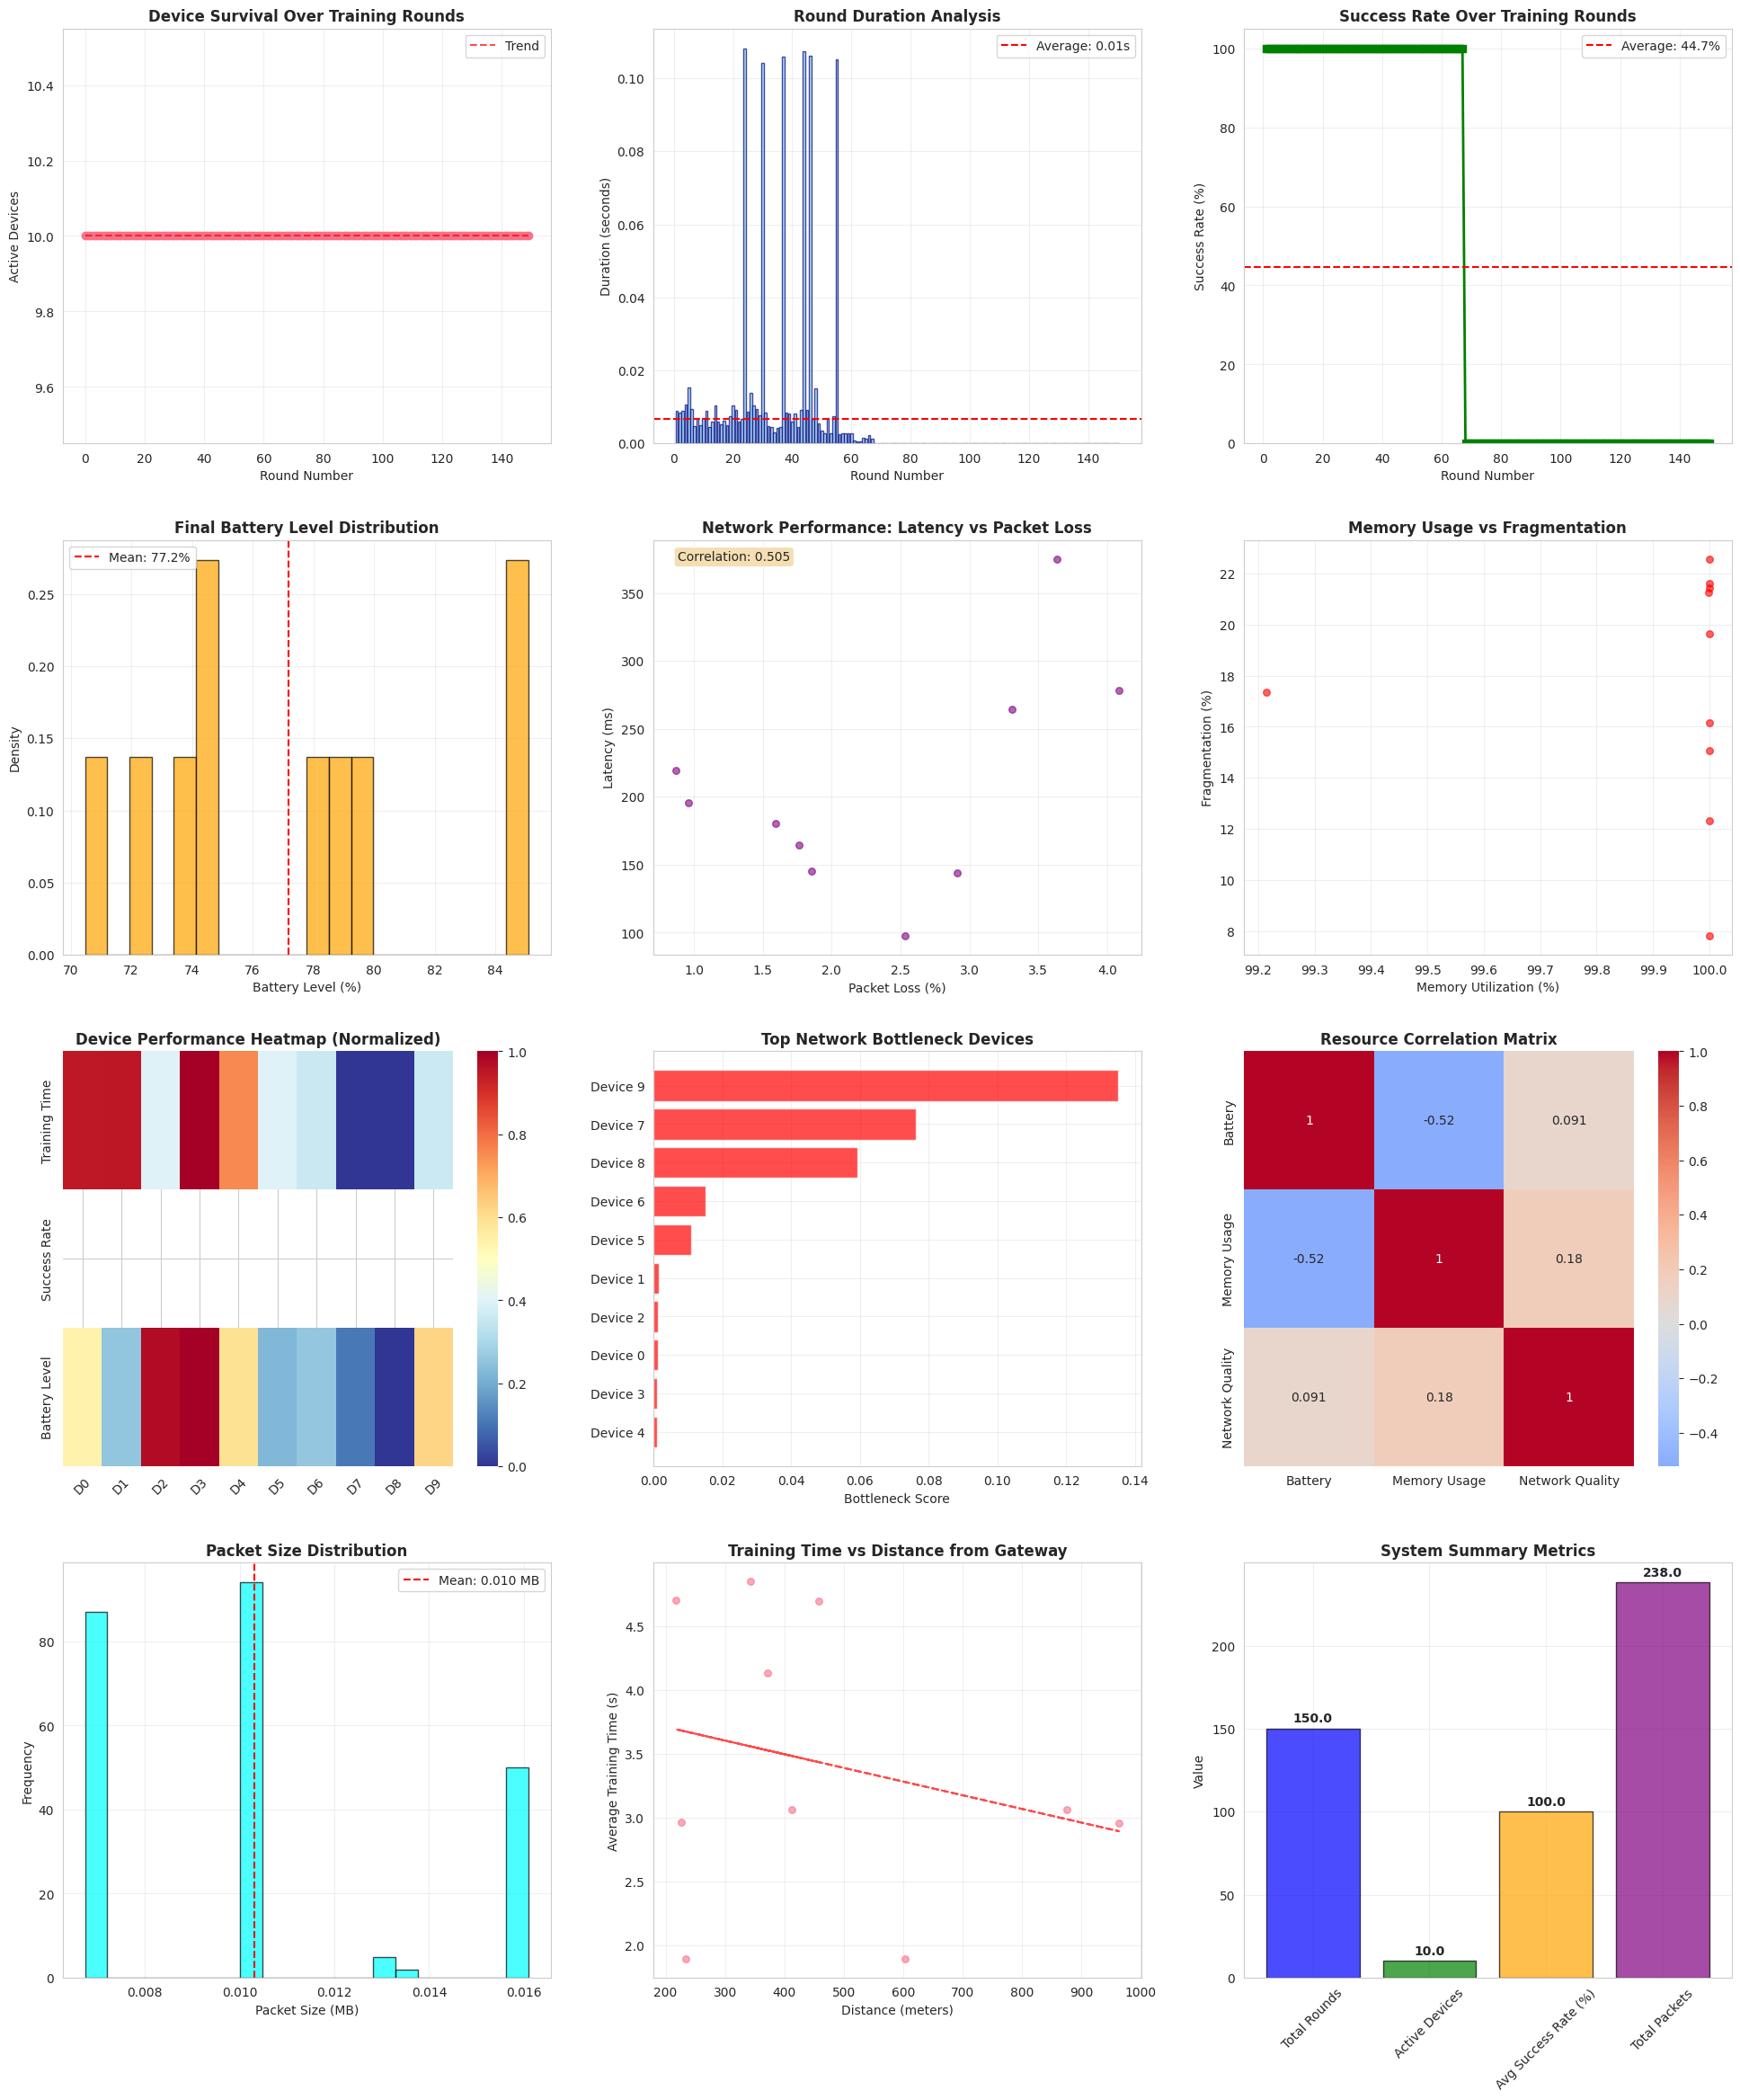

📄 Generating Detailed Report...
FEDERATED LEARNING IoT SYSTEM - DETAILED ANALYSIS REPORT

📊 SYSTEM OVERVIEW:
   • Total Devices: 10
   • Final Active Devices: 10 (100.0%)
   • Total Training Rounds: 150
   • Device Selection Policy: Random

⏱️  TIMING ANALYSIS:
   • Average Round Duration: 0.01s
   • Min Round Duration: 0.00s
   • Max Round Duration: 0.11s
   • Total System Runtime: 1.02s

📈 SUCCESS METRICS:
   • Average Success Rate: 100.0%
   • Min Success Rate: 100.0%
   • Max Success Rate: 100.0%
   • Total Packets Transmitted: 238

🔋 RESOURCE ANALYSIS:
   • Average Final Battery Level: 77.2%
   • Devices with Critical Battery (<10%): 0
   • Battery-related Failures: 0

🌐 NETWORK ANALYSIS:
   • Average Packet Loss: 2.35%
   • Average Latency: 206.4ms
   • High Latency Devices (>100ms): 9

🚫 BOTTLENECK ANALYSIS:
   • Slow Training Devices (>90th percentile): 1
   • Device IDs with Performance Issues: [3]

💡 RECOMMENDATIONS:
   • Network performance issues detected - consider retry m

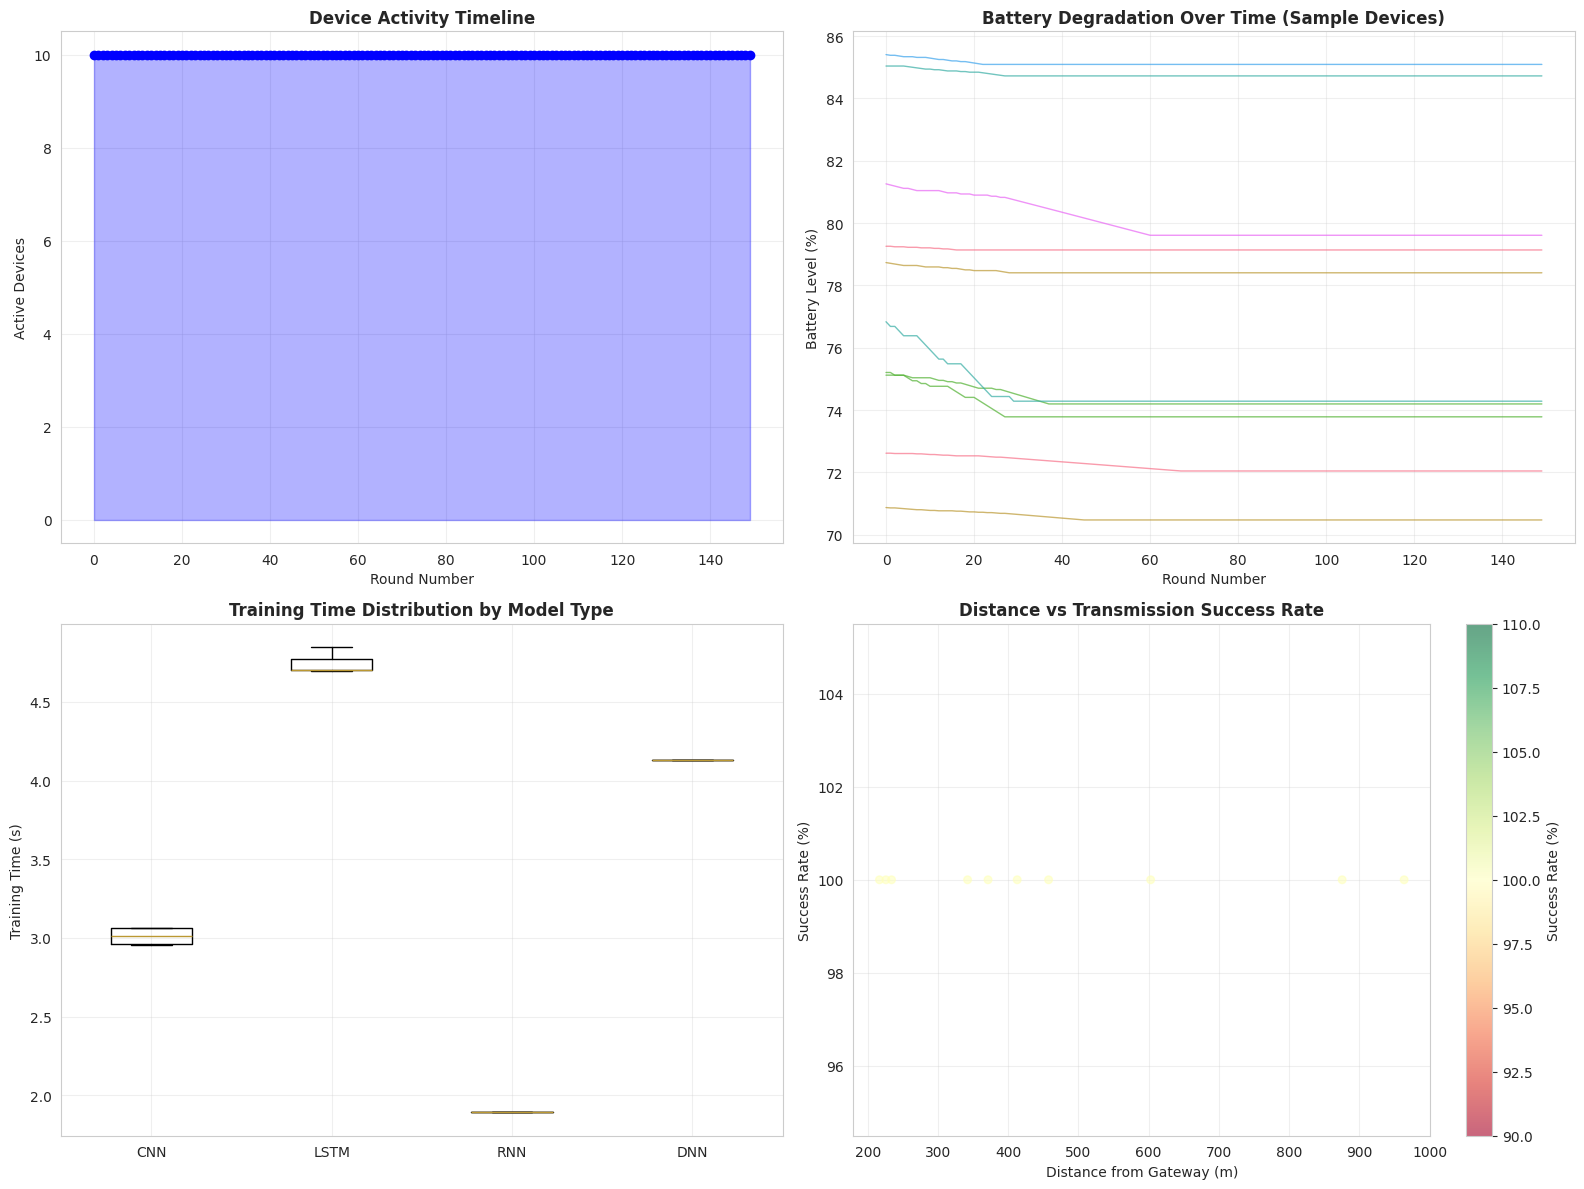

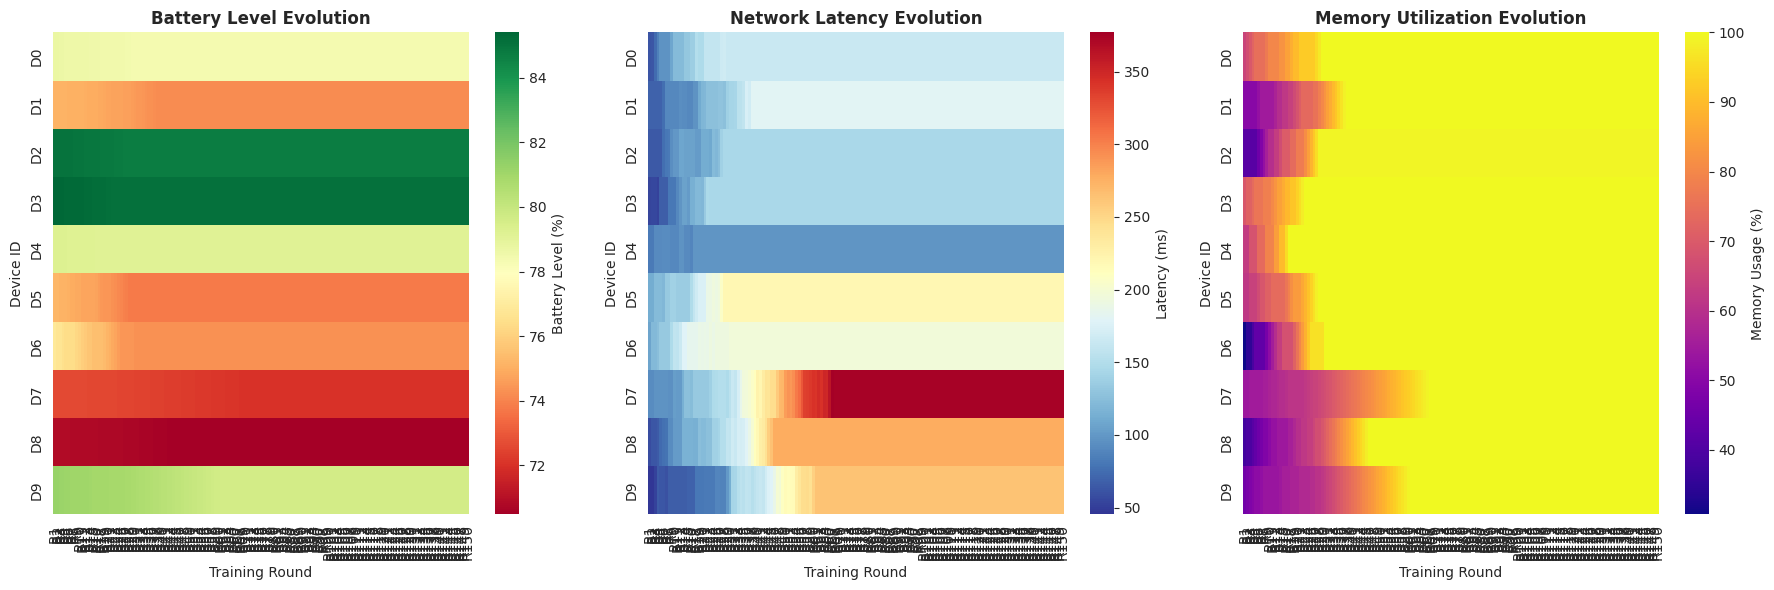

In [11]:
def main():
    """Main execution function with comprehensive analysis"""
    print("🚀 Initializing Federated Learning IoT System...")
    
    # Create and run simulation
    fl_system = FederatedLearningSystem(num_devices=10, selection_size=5)
    
    # Run simulation with random policy
    print("\n📊 Running Simulation...")
    system_stats = fl_system.run_simulation(num_rounds=150, policy="random")
    
    # Create performance analyzer
    print("\n📈 Generating Performance Analysis...")
    analyzer = PerformanceAnalyzer(fl_system)
    
    # Generate comprehensive dashboard
    print("🎨 Creating Visualization Dashboard...")
    analyzer.create_comprehensive_dashboard()
    
    # Generate detailed report
    print("📄 Generating Detailed Report...")
    detailed_report = analyzer.generate_detailed_report()
    print(detailed_report)
    
    # Save report to file
    with open('federated_learning_report.txt', 'w') as f:
        f.write(detailed_report)
    
    print("\n✅ Analysis Complete!")
    print("📊 Dashboard saved as: federated_learning_dashboard.png")
    print("📄 Report saved as: federated_learning_report.txt")
    
    # Additional specific analysis plots
    create_additional_analysis_plots(fl_system)
    
    return fl_system, system_stats

# Run the simulation
fl_system, stats = main()